# DSAI CS1015 MINI PROJECT FSP3 TEAM 8

    By: TAN MEI XUAN (U1921903J), SEAH YONG ZHI (U1922524L), GOH CHENG GUAN, CLIVE (U1920078G)
    Dataset: Jester Joke Dataset

## Problem Statement/Objective
    To identify whether there’s diverse group with contrasting likes and dislikes of various jokes.
    
## Machine Learning
    Unsupervised Learning - Clustering based on User Ratings

# Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud

from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score


%matplotlib inline
sb.set(font_scale=1.3) # set the default Seaborn style for graphics

# #1. Visualisation for JokeText: Count Plot + Word Cloud

## #1.1: Data Cleaning for Word Cloud (Cleaned_Jokes.csv)

In [2]:
Jokes = pd.read_csv("data reference/JokeText.csv")
Jokes['Cleaned Reviews']=Jokes['JokeText']
#remove all punctuation and change all to lower case
Jokes['Cleaned Reviews']=Jokes['Cleaned Reviews'].str.replace('[^\w\s]',' ').str.lower()
#remove \n and\t
Jokes['Cleaned Reviews']=Jokes['Cleaned Reviews'].str.replace('\n',' ').str.replace('\t',' ')

#get stopword from NLTK
stopping = stopwords.words('english')
#remove stop word
Jokes['Cleaned Reviews']=Jokes['Cleaned Reviews'].str.split(' ').apply(lambda x: ' '.join(word for word in x if word not in stopping))
#remove letter q
Jokes['Cleaned Reviews']=Jokes['Cleaned Reviews'].str.split(' ').apply(lambda x: ' '.join(word for word in x if word not in 'q'))
#Jokes.head()

In [3]:
#export as csv file
Jokes.to_csv('data reference/Cleaned_Jokes.csv', index = False)

In [4]:
prep_for_counting = Jokes['Cleaned Reviews']
token = [word_tokenize(str(i)) for i in prep_for_counting] #tokenize words in lists


#flatten the list to make a single list containing all words (repeat included)
flatten_list = []
for sublist in token:
    for item in sublist:
        flatten_list.append(item)

#Counter used to determine the number of repeats
from collections import Counter 
counted_words = Counter(flatten_list)
#counted_words.most_common(20)

In [5]:
#preping for export to CSV file
Word_counter = pd.DataFrame(counted_words.most_common())
Word_counter.columns = ['Word being Counted', 'Counting Result']
Word_counter.to_csv('data reference/Word_Counter.csv', index = False)

## #1.2: Count Plot - Most Common Words

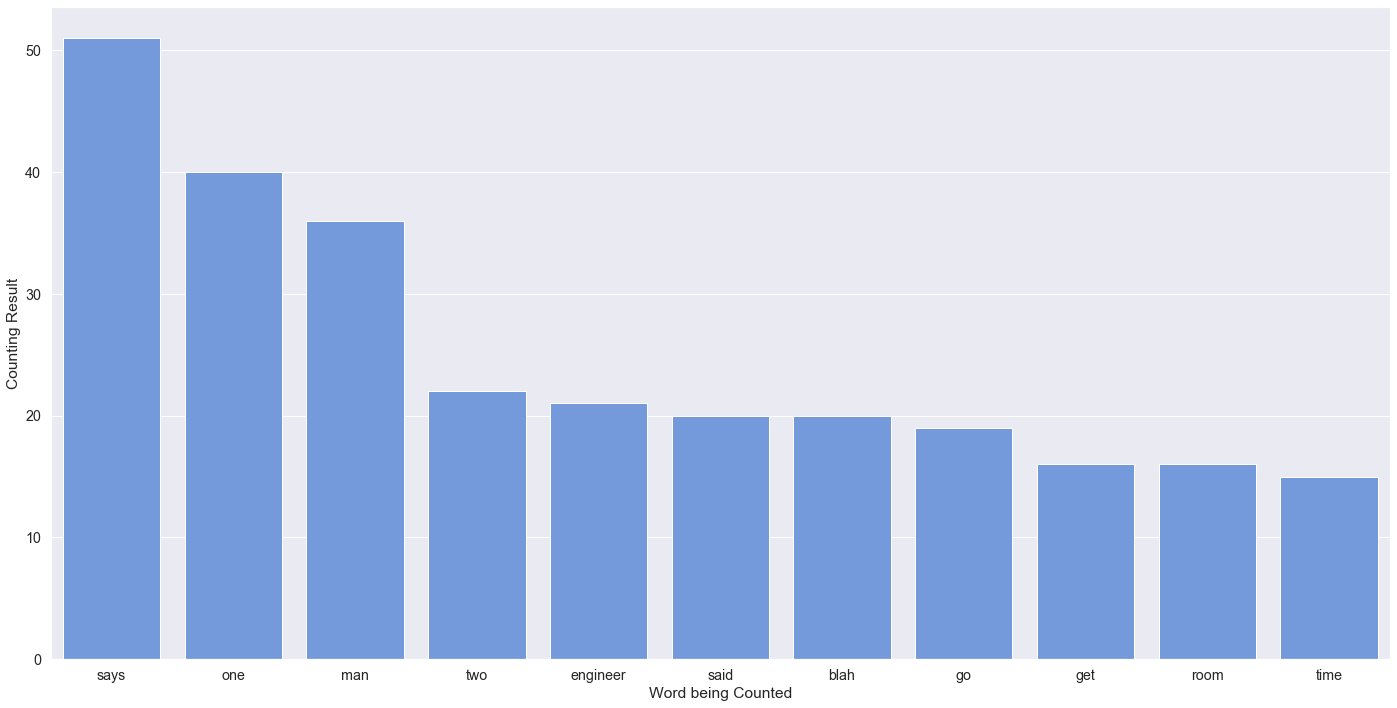

In [6]:
top10_df=Word_counter.head(11)
f, axes = plt.subplots(1, 1, figsize=(24, 12))
sb.barplot(x = 'Word being Counted',y="Counting Result", data = top10_df,color="cornflowerblue")

## #1.3: Word Cloud - Most Common Words

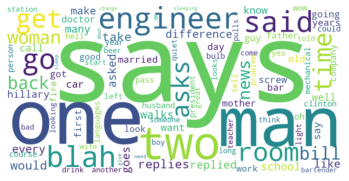

In [7]:

text=("Python Python Python Matplotlib Matplotlib Seaborn Network Plot Violin Chart Pandas Datascience Wordcloud Spider Radar Parrallel Alpha Color Brewer Density Scatter Barplot Barplot Boxplot Violinplot Treemap Stacked Area Chart Chart Visualization Dataviz Donut Pie Time-Series Wordcloud Wordcloud Sankey Bubble")
# Create the wordcloud object
wordcloud = WordCloud(background_color='white',width=1000, height=500, margin=0,max_words=100)
wordcloud.generate_from_frequencies(counted_words)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figsize=(100,100)
#plt.margins(x=0, y=0)
plt.show()


> The size of the word determines the count of each word in the jokes
e.g. **says** is the biggest with most no. of count

# #2. Data Cleaning for Main Dataset (Cleaned Dataset-Joker.csv)

In [8]:
#import rating
raw_rating = pd.read_excel("data reference/jester-data-1-with-header.xls")
raw_rating.head()

Number of Jokes Rated  Joke 1  Joke 2  Joke 3  Joke 4  Joke 5  Joke 6  \
0                     74   -7.82    8.79   -9.66   -8.16   -7.52   -8.50   
1                    100    4.08   -0.29    6.36    4.37   -2.38   -9.66   
2                     49   99.00   99.00   99.00   99.00    9.03    9.27   
3                     48   99.00    8.35   99.00   99.00    1.80    8.16   
4                     91    8.50    4.61   -4.17   -5.39    1.36    1.60   

   Joke 7  Joke 8  Joke 9  ...  Joke 91  Joke 92  Joke 93  Joke 94  Joke 95  \
0   -9.85    4.17   -8.98  ...     2.82    99.00    99.00    99.00    99.00   
1   -0.73   -5.34    8.88  ...     2.82    -4.95    -0.29     7.86    -0.19   
2    9.03    9.27   99.00  ...    99.00    99.00    99.00     9.08    99.00   
3   -2.82    6.21   99.00  ...    99.00    99.00    99.00     0.53    99.00   
4    7.04    4.61   -0.44  ...     5.19     5.58     4.27     5.19     5.73   

   Joke 96  Joke 97  Joke 98  Joke 99  Joke 100  
0    99.00    -5.63    99.00    99.00     99.00  
1    -2.14     3.06     0.34    -4.32      1.07  
2    99.00    99.00    99.00    99.00     99.00  
3    99.00    99.00    99.00    99.00     99.00  
4     1.55     3.11     6.55     1.80      1.60  

[5 rows x 101 columns]

#### Using only 10000 User's Ratings

In [9]:
#replace 99.00 with 0 which is a netural
raw_rating=raw_rating.replace(99.00,0)
#drop the column that contain Number of joke rated
raw_rating.drop(['Number of Jokes Rated'], axis=1,inplace=True)
#reindex so that the first row is 1, the first user
raw_rating.index= np.arange(1, len(raw_rating) + 1)
raw_rating=raw_rating.head(10000)
raw_rating.head(5)

Joke 1  Joke 2  Joke 3  Joke 4  Joke 5  Joke 6  Joke 7  Joke 8  Joke 9  \
1   -7.82    8.79   -9.66   -8.16   -7.52   -8.50   -9.85    4.17   -8.98   
2    4.08   -0.29    6.36    4.37   -2.38   -9.66   -0.73   -5.34    8.88   
3    0.00    0.00    0.00    0.00    9.03    9.27    9.03    9.27    0.00   
4    0.00    8.35    0.00    0.00    1.80    8.16   -2.82    6.21    0.00   
5    8.50    4.61   -4.17   -5.39    1.36    1.60    7.04    4.61   -0.44   

   Joke 10  ...  Joke 91  Joke 92  Joke 93  Joke 94  Joke 95  Joke 96  \
1    -4.76  ...     2.82     0.00     0.00     0.00     0.00     0.00   
2     9.22  ...     2.82    -4.95    -0.29     7.86    -0.19    -2.14   
3     0.00  ...     0.00     0.00     0.00     9.08     0.00     0.00   
4     1.84  ...     0.00     0.00     0.00     0.53     0.00     0.00   
5     5.73  ...     5.19     5.58     4.27     5.19     5.73     1.55   

   Joke 97  Joke 98  Joke 99  Joke 100  
1    -5.63     0.00     0.00      0.00  
2     3.06     0.34    -4.32      1.07  
3     0.00     0.00     0.00      0.00  
4     0.00     0.00     0.00      0.00  
5     3.11     6.55     1.80      1.60  

[5 rows x 100 columns]

#### This 'flipped_rating' portion might take awhile to load as it needs to remove 'User' from 10000 rows 

In [10]:
flipped_rating=pd.DataFrame(raw_rating).T
#comment the for loop to remove te "User" word from the table
for var in range(1,24984):
    flipped_rating.rename(columns={var: 'User '+ str(var)}, inplace=True)
flipped_rating.head()

User 1  User 2  User 3  User 4  User 5  User 6  User 7  User 8  \
Joke 1   -7.82    4.08    0.00    0.00    8.50   -6.17    0.00    6.84   
Joke 2    8.79   -0.29    0.00    8.35    4.61   -3.54    0.00    3.16   
Joke 3   -9.66    6.36    0.00    0.00   -4.17    0.44    0.00    9.17   
Joke 4   -8.16    4.37    0.00    0.00   -5.39   -8.50    0.00   -6.21   
Joke 5   -7.52   -2.38    9.03    1.80    1.36   -7.09    8.59   -8.16   

        User 9  User 10  ...  User 9991  User 9992  User 9993  User 9994  \
Joke 1   -3.79     3.01  ...      -6.99      -2.43       0.00       5.10   
Joke 2   -3.54     5.15  ...      -6.84      -3.40       0.00       5.24   
Joke 3   -9.42     5.15  ...      -7.28       0.87       0.00       3.45   
Joke 4   -6.89     3.01  ...      -0.73       0.00       0.00       0.00   
Joke 5   -8.74     6.41  ...      -6.70       1.80       2.04       1.02   

        User 9995  User 9996  User 9997  User 9998  User 9999  User 10000  
Joke 1       0.00       6.70      -6.31      -9.71       3.74        0.00  
Joke 2       0.00      -8.98      -5.78      -9.71       3.93        7.33  
Joke 3       0.00       0.68       2.77       6.70       3.40        4.81  
Joke 4       0.00       1.99       0.00      -9.71       3.98        0.00  
Joke 5       6.46       0.78      -4.90       2.67       3.45        1.46  

[5 rows x 10000 columns]

In [11]:
flipped_rating.to_csv('data reference/DataPreparation-1.csv', index = True)
flipped_rating.head()

User 1  User 2  User 3  User 4  User 5  User 6  User 7  User 8  \
Joke 1   -7.82    4.08    0.00    0.00    8.50   -6.17    0.00    6.84   
Joke 2    8.79   -0.29    0.00    8.35    4.61   -3.54    0.00    3.16   
Joke 3   -9.66    6.36    0.00    0.00   -4.17    0.44    0.00    9.17   
Joke 4   -8.16    4.37    0.00    0.00   -5.39   -8.50    0.00   -6.21   
Joke 5   -7.52   -2.38    9.03    1.80    1.36   -7.09    8.59   -8.16   

        User 9  User 10  ...  User 9991  User 9992  User 9993  User 9994  \
Joke 1   -3.79     3.01  ...      -6.99      -2.43       0.00       5.10   
Joke 2   -3.54     5.15  ...      -6.84      -3.40       0.00       5.24   
Joke 3   -9.42     5.15  ...      -7.28       0.87       0.00       3.45   
Joke 4   -6.89     3.01  ...      -0.73       0.00       0.00       0.00   
Joke 5   -8.74     6.41  ...      -6.70       1.80       2.04       1.02   

        User 9995  User 9996  User 9997  User 9998  User 9999  User 10000  
Joke 1       0.00       6.70      -6.31      -9.71       3.74        0.00  
Joke 2       0.00      -8.98      -5.78      -9.71       3.93        7.33  
Joke 3       0.00       0.68       2.77       6.70       3.40        4.81  
Joke 4       0.00       1.99       0.00      -9.71       3.98        0.00  
Joke 5       6.46       0.78      -4.90       2.67       3.45        1.46  

[5 rows x 10000 columns]

In [12]:
second_raw=pd.read_csv("data reference/DataPreparation-1.csv")
second_raw.rename( columns={'Unnamed: 0':'Joke Listing'}, inplace=True )
#second_raw=second_raw.head(10003)
second_raw.head(5)

Joke Listing  User 1  User 2  User 3  User 4  User 5  User 6  User 7  \
0       Joke 1   -7.82    4.08    0.00    0.00    8.50   -6.17    0.00   
1       Joke 2    8.79   -0.29    0.00    8.35    4.61   -3.54    0.00   
2       Joke 3   -9.66    6.36    0.00    0.00   -4.17    0.44    0.00   
3       Joke 4   -8.16    4.37    0.00    0.00   -5.39   -8.50    0.00   
4       Joke 5   -7.52   -2.38    9.03    1.80    1.36   -7.09    8.59   

   User 8  User 9  ...  User 9991  User 9992  User 9993  User 9994  User 9995  \
0    6.84   -3.79  ...      -6.99      -2.43       0.00       5.10       0.00   
1    3.16   -3.54  ...      -6.84      -3.40       0.00       5.24       0.00   
2    9.17   -9.42  ...      -7.28       0.87       0.00       3.45       0.00   
3   -6.21   -6.89  ...      -0.73       0.00       0.00       0.00       0.00   
4   -8.16   -8.74  ...      -6.70       1.80       2.04       1.02       6.46   

   User 9996  User 9997  User 9998  User 9999  User 10000  
0       6.70      -6.31      -9.71       3.74        0.00  
1      -8.98      -5.78      -9.71       3.93        7.33  
2       0.68       2.77       6.70       3.40        4.81  
3       1.99       0.00      -9.71       3.98        0.00  
4       0.78      -4.90       2.67       3.45        1.46  

[5 rows x 10001 columns]

####  JokeText_Category.csv is derived from Cleaned_Jokes.csv [csv created from #1.1] + Manual keying of category column


In [13]:
mean_df=pd.DataFrame(second_raw)
mean_df.drop(['Joke Listing'], axis=1,inplace=True)
mean_df['Mean of Joke'] = mean_df.mean(axis=1)

##JokeText_Category.csv is derived from Cleaned Reviews + Manual keying of category column
jokes_catergory=pd.read_excel("data reference/JokeText_Category.xlsx")
catergory_extractor=pd.DataFrame()
catergory_extractor["JokeId"]=jokes_catergory["JokeId"]
catergory_extractor["JokeText"]=jokes_catergory["JokeText"]
catergory_extractor["Type of Jokes"]=jokes_catergory["Type_of_Jokes"]

In [14]:
second_raw.insert(1, 'JokeText', catergory_extractor['JokeText'])
second_raw.insert(2, 'Type of Jokes', catergory_extractor['Type of Jokes'])
second_raw.insert(3, 'Mean of Joke', mean_df['Mean of Joke'])

In [15]:
second_raw.set_index('Joke Listing',inplace=True)
second_raw=second_raw.T

In [16]:
second_raw.to_csv('data reference/DataPreparation-2.csv', index = True)

In [17]:
third_raw=pd.read_csv("data reference/DataPreparation-2.csv")
third_raw.rename( columns={'Unnamed: 0':'Joke Listing'}, inplace=True )
third_raw.head(5)

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Joke Listing                                             Joke 1  \
0       JokeText  A man visits the doctor. The doctor says "I ha...   
1  Type of Jokes                                             Ironic   
2   Mean of Joke                                 0.6186279999999965   
3         User 1                                              -7.82   
4         User 2                                               4.08   

                                              Joke 2  \
0  This couple had an excellent relationship goin...   
1                                               Dark   
2                                0.14438500000000018   
3                                               8.79   
4                                              -0.29   

                                              Joke 3  \
0  Q. What's 200 feet long and has 4 teeth? \n\nA...   
1                                          Reference   
2                                 0.1897610000000012   
3                                              -9.66   
4                                               6.36   

                                              Joke 4  \
0  Q. What's the difference between a man and a t...   
1                                          Reference   
2                                -0.9087330000000011   
3                                              -8.16   
4                                               4.37   

                                              Joke 5  \
0  Q.\tWhat's O. J. Simpson's Internet address? \...   
1                                           Wordplay   
2                                 0.3332050000000001   
3                                              -7.52   
4                                              -2.38   

                                              Joke 6  \
0  Bill & Hillary are on a trip back to Arkansas....   
1                                    Political Humor   
2                                 1.4015940000000007   
3                                               -8.5   
4                                              -9.66   

                                              Joke 7  \
0  How many feminists does it take to screw in a ...   
1                                          Reference   
2                               -0.48715300000000133   
3                                              -9.85   
4                                              -0.73   

                                              Joke 8  \
0  Q. Did you hear about the dyslexic devil worsh...   
1                                           Wordplay   
2                                -0.7495670000000003   
3                                               4.17   
4                                              -5.34   

                                              Joke 9  ...  \
0  A country guy goes into a city bar that has a ...  ...   
1                                           Wordplay  ...   
2                               -0.23881899999999995  ...   
3                                              -8.98  ...   
4                                               8.88  ...   

                                             Joke 91  \
0  A Panda bear walks into a bar.  Sits down at a...   
1                                             Ironic   
2                                 0.8079710000000008   
3                                               2.82   
4                                               2.82   

                                             Joke 92  \
0  Early one morning a mother went to her sleepin...   
1                                          Reference   
2                                 0.4805680000000011   
3                                                0.0   
4                                              -4.95   

                                             Joke 93  \
0  Reaching the end of a job interview, the human...   
1                                           Juvenile   
2        

In [18]:
#export the main dataframe into csv for better viewing
third_raw.to_csv('Cleaned Dataset-Joker.csv', index = False)

In [19]:
df=pd.read_csv('Cleaned Dataset-Joker.csv')
df.head(10)

Joke Listing                                             Joke 1  \
0       JokeText  A man visits the doctor. The doctor says "I ha...   
1  Type of Jokes                                             Ironic   
2   Mean of Joke                                 0.6186279999999965   
3         User 1                                              -7.82   
4         User 2                                               4.08   
5         User 3                                                0.0   
6         User 4                                                0.0   
7         User 5                                                8.5   
8         User 6                                              -6.17   
9         User 7                                                0.0   

                                              Joke 2  \
0  This couple had an excellent relationship goin...   
1                                               Dark   
2                                0.14438500000000018   
3                                               8.79   
4                                              -0.29   
5                                                0.0   
6                                               8.35   
7                                               4.61   
8                                              -3.54   
9                                                0.0   

                                              Joke 3  \
0  Q. What's 200 feet long and has 4 teeth? \n\nA...   
1                                          Reference   
2                                 0.1897610000000012   
3                                              -9.66   
4                                               6.36   
5                                                0.0   
6                                                0.0   
7                                              -4.17   
8                                               0.44   
9                                                0.0   

                                              Joke 4  \
0  Q. What's the difference between a man and a t...   
1                                          Reference   
2                                -0.9087330000000011   
3                                              -8.16   
4                                               4.37   
5                                                0.0   
6                                                0.0   
7                                              -5.39   
8                                               -8.5   
9                                                0.0   

                                              Joke 5  \
0  Q.\tWhat's O. J. Simpson's Internet address? \...   
1                                           Wordplay   
2                                 0.3332050000000001   
3                                              -7.52   
4                                              -2.38   
5                                               9.03   
6                                                1.8   
7                                               1.36   
8                                              -7.09   
9                                               8.59   

                                              Joke 6  \
0  Bill & Hillary are on a trip back to Arkansas....   
1                                    Political Humor   
2                                 1.4015940000000007   
3                                               -8.5   
4                                              -9.66   
5                                               9.27   
6                                               8.16   
7                                                1.6   
8                                              -4.32   
9                                              -9.85   

                                              Joke 7  \
0  How many feminists does it take to screw in a ...   
1                        

# #3. Network Visualization for Different Type of Jokes

#### Dataframe containing the category and mean ratings (over 10000 users)

In [20]:
#using dataframe created at #2. Data Cleaning for Main Dataset 
jokes_catergory["Mean"]=mean_df['Mean of Joke']
joke_catmean = jokes_catergory
joke_catmean.head()

JokeId                                           JokeText  \
0       0  A man visits the doctor. The doctor says "I ha...   
1       1  This couple had an excellent relationship goin...   
2       2  Q. What's 200 feet long and has 4 teeth? \n\nA...   
3       3  Q. What's the difference between a man and a t...   
4       4  Q.\tWhat's O. J. Simpson's Internet address? \...   

                                       Cleaned_Jokes Type_of_Jokes      Mean  
0  man visits doctor doctor says bad news cancer ...        Ironic  0.618628  
1  couple excellent relationship going one day ca...          Dark  0.144385  
2  200 feet long 4 teeth front row willie nelson ...     Reference  0.189761  
3     difference man toilet toilet follow around use     Reference -0.908733  
4  j simpson internet address slash slash backsla...      Wordplay  0.333205

## #3.1: Unigram Network Dataframe Codes
##### for Trigram (2-words), just change to 'for ngram in generate_ngrams(title, 2):'  
##### using 'Cleaned_Jokes' that does not contains stopwords (such as “the”, “a”, “an”, “in”) 

In [21]:
def generate_ngrams(text, n=2):
    words = text.split()
    iterations = len(words) - n + 1
    for i in range(iterations):
       yield words[i:i + n]

In [22]:
# DataFrame for Dark
ngrams = {}
for title in joke_catmean[joke_catmean.Type_of_Jokes=="Dark"]['Cleaned_Jokes']:
        for ngram in generate_ngrams(title, 1):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_Dark_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_Dark_df.columns = ['count']
ngrams_Dark_df['Type_of_Jokes'] = 'Dark'
ngrams_Dark_df.reset_index(level=0, inplace=True)

# DataFrame for Ironic
ngrams = {}
for title in joke_catmean[joke_catmean.Type_of_Jokes=="Ironic"]['Cleaned_Jokes']:
        for ngram in generate_ngrams(title, 1):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_Ironic_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_Ironic_df.columns = ['count']
ngrams_Ironic_df['Type_of_Jokes'] = 'Ironic'
ngrams_Ironic_df.reset_index(level=0, inplace=True)

# DataFrame for Juvenile
ngrams = {}
for title in joke_catmean[joke_catmean.Type_of_Jokes=="Juvenile"]['Cleaned_Jokes']:
        for ngram in generate_ngrams(title, 1):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_Juvenile_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_Juvenile_df.columns = ['count']
ngrams_Juvenile_df['Type_of_Jokes'] = 'Juvenile'
ngrams_Juvenile_df.reset_index(level=0, inplace=True)

# DataFrame for Political Humor
ngrams = {}
for title in joke_catmean[joke_catmean.Type_of_Jokes=="Political Humor"]['Cleaned_Jokes']:
        for ngram in generate_ngrams(title, 1):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_Poli_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_Poli_df.columns = ['count']
ngrams_Poli_df['Type_of_Jokes'] = 'Political Humor'
ngrams_Poli_df.reset_index(level=0, inplace=True)

# DataFrame for Reference
ngrams = {}
for title in joke_catmean[joke_catmean.Type_of_Jokes=="Reference"]['Cleaned_Jokes']:
        for ngram in generate_ngrams(title, 1):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_Reference_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_Reference_df.columns = ['count']
ngrams_Reference_df['Type_of_Jokes'] = 'Reference'
ngrams_Reference_df.reset_index(level=0, inplace=True)

# DataFrame for Wordplay
ngrams = {}
for title in joke_catmean[joke_catmean.Type_of_Jokes=="Wordplay"]['Cleaned_Jokes']:
        for ngram in generate_ngrams(title, 1):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_Wordplay_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_Wordplay_df.columns = ['count']
ngrams_Wordplay_df['Type_of_Jokes'] = 'Wordplay'
ngrams_Wordplay_df.reset_index(level=0, inplace=True)

#### Sample View of each Word Count in different Category

In [23]:
ngrams_Dark_df.sort_values(by='count', ascending=False).head(5)

index  count Type_of_Jokes
185    man     11          Dark
112   news     11          Dark
43    says     10          Dark
247  woman      7          Dark
303  would      7          Dark

In [24]:
ngrams_Ironic_df.sort_values(by='count', ascending=False).head(5)

index  count Type_of_Jokes
18      one      7        Ironic
189  course      5        Ironic
226    bear      5        Ironic
0       man      4        Ironic
95     asks      4        Ironic

In [25]:
ngrams_Juvenile_df.sort_values(by='count', ascending=False).head(5)

index  count Type_of_Jokes
14        says     10      Juvenile
13         wow      6      Juvenile
25   languages      5      Juvenile
225   negative      5      Juvenile
31        call      5      Juvenile

In [26]:
ngrams_Poli_df.sort_values(by='count', ascending=False).head(5)

index  count    Type_of_Jokes
0        bill     11  Political Humor
49        one      8  Political Humor
1     hillary      7  Political Humor
41  president      6  Political Humor
42    clinton      6  Political Humor

In [27]:
ngrams_Reference_df.sort_values(by='count', ascending=False).head(5)

index  count Type_of_Jokes
447      blah     20     Reference
11        man     17     Reference
94   engineer     13     Reference
75        one     13     Reference
50       says     13     Reference

In [28]:
ngrams_Wordplay_df.sort_values(by='count', ascending=False).head(5)

index  count Type_of_Jokes
44   says      9      Wordplay
38   like      9      Wordplay
126  back      7      Wordplay
192  fire      7      Wordplay
234  said      7      Wordplay

## #3.2: Unigram Network Visualization (NetworkX Graph)


In [29]:
unigram_df = pd.concat([ngrams_Dark_df.sort_values(by='count', ascending=False).head(5),
                        ngrams_Ironic_df.sort_values(by='count', ascending=False).head(5),
                        ngrams_Juvenile_df.sort_values(by='count', ascending=False).head(5),
                        ngrams_Poli_df.sort_values(by='count', ascending=False).head(5),
                        ngrams_Reference_df.sort_values(by='count', ascending=False).head(5),
                        ngrams_Wordplay_df.sort_values(by='count', ascending=False).head(5)])

In [30]:
g = nx.from_pandas_edgelist(unigram_df,source='Type_of_Jokes',target='index')
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 30
Average degree:   2.0690


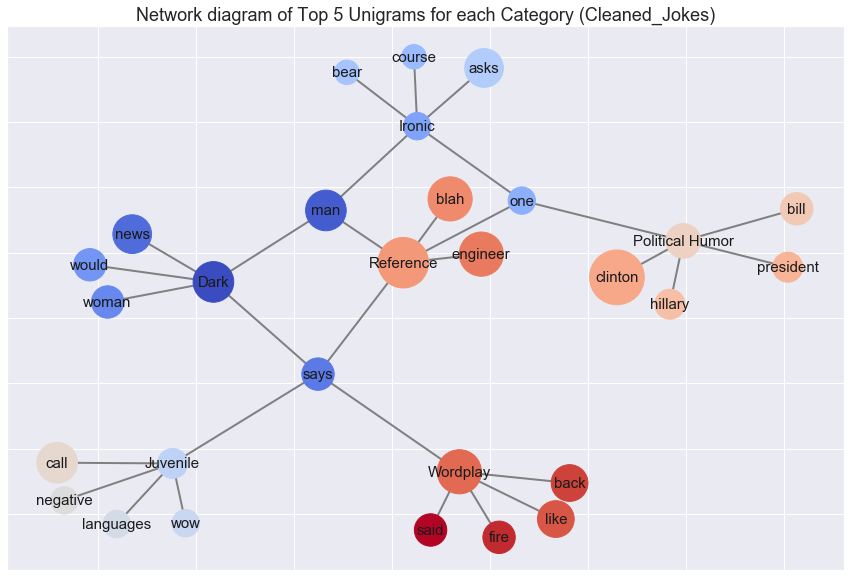

In [103]:
plt.figure(figsize=(15, 10))
cmap = plt.cm.coolwarm
colors = [n for n in range(len(g.nodes()))]
k = 0.15
pos=nx.spring_layout(g, k=k)
nx.draw_networkx(g,pos, node_size=unigram_df['count'].values*150, cmap = cmap, 
                 node_color=colors, edge_color='grey', font_size=15, width=2, alpha=1)
plt.title("Network diagram of Top 5 Unigrams for each Category (Cleaned_Jokes)",
         fontsize=18)
plt.show()

##the bigger the circle = larger count of the words 

> Political Humor: have words mostly related to president.  Dark: have words like news (bad / good news)

# #4. Statistical Visualisation for Jokes Ratings

## #4.1: Catplot - Type of Jokes in Dataset

In [32]:
joke_catmean['Type_of_Jokes'] = joke_catmean['Type_of_Jokes'].astype('category')

In [33]:
joke_catmean['Type_of_Jokes'].describe()

count          100
unique           6
top       Wordplay
freq            27
Name: Type_of_Jokes, dtype: object

In [34]:
print(joke_catmean['Type_of_Jokes'].value_counts())

Wordplay           27
Reference          27
Dark               13
Ironic             12
Juvenile           11
Political Humor    10
Name: Type_of_Jokes, dtype: int64


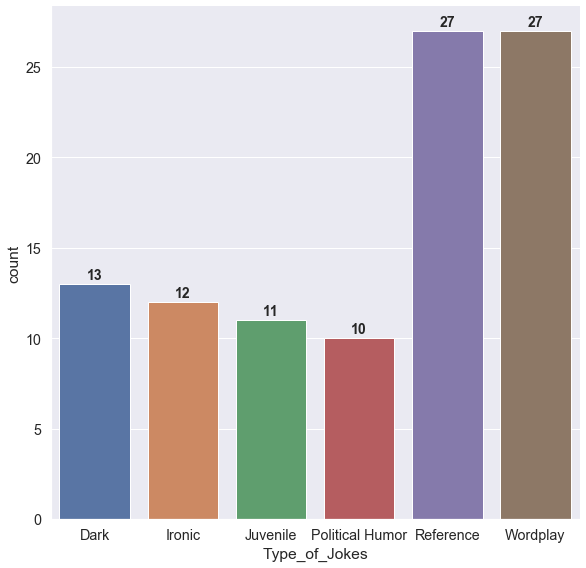

In [35]:
plot = sb.catplot(x = 'Type_of_Jokes', data = joke_catmean, kind = "count", height = 8)
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+0.5, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=14)

> The category with most number of jokes is 'Reference' and 'Wordplay' with 27 each.

## #4.2: Boxplot - Average Ratings per Category

In [36]:
joke_catmean.head()

JokeId                                           JokeText  \
0       0  A man visits the doctor. The doctor says "I ha...   
1       1  This couple had an excellent relationship goin...   
2       2  Q. What's 200 feet long and has 4 teeth? \n\nA...   
3       3  Q. What's the difference between a man and a t...   
4       4  Q.\tWhat's O. J. Simpson's Internet address? \...   

                                       Cleaned_Jokes Type_of_Jokes      Mean  
0  man visits doctor doctor says bad news cancer ...        Ironic  0.618628  
1  couple excellent relationship going one day ca...          Dark  0.144385  
2  200 feet long 4 teeth front row willie nelson ...     Reference  0.189761  
3     difference man toilet toilet follow around use     Reference -0.908733  
4  j simpson internet address slash slash backsla...      Wordplay  0.333205

#### Different type of jokes dataframe

In [37]:
Ironic_boxplt = joke_catmean.loc[joke_catmean['Type_of_Jokes']=='Ironic',['Mean']]
Reference_boxplt = joke_catmean.loc[joke_catmean['Type_of_Jokes']=='Reference',['Mean']]
Wordplay_boxplt = joke_catmean.loc[joke_catmean['Type_of_Jokes']=='Wordplay',['Mean']]
Dark_boxplt = joke_catmean.loc[joke_catmean['Type_of_Jokes']=='Dark',['Mean']]
Juvenile_boxplt = joke_catmean.loc[joke_catmean['Type_of_Jokes']=='Juvenile',['Mean']]
Political_boxplt = joke_catmean.loc[joke_catmean['Type_of_Jokes']=='Political Humor',['Mean']]

In [38]:
### Sample view of the dataframe created
Political_boxplt.head()

Mean
5   1.401594
26  3.190419
30  2.239872
50 -0.476369
51  0.026178

#### Concate all different type of jokes dataframe into one boxplot dataframe

In [39]:
boxplot_df = pd.concat([Ironic_boxplt.rename(columns={Ironic_boxplt.columns[0]: "Ironic_Mean" })
, Reference_boxplt.rename(columns={ Reference_boxplt.columns[0]: "Reference_Mean" })
, Wordplay_boxplt.rename(columns={ Wordplay_boxplt.columns[0]: "Wordplay_Mean" }), Dark_boxplt.rename(columns={ Dark_boxplt.columns[0]: "Dark_Mean" }), Juvenile_boxplt.rename(columns={ Juvenile_boxplt.columns[0]: "Juvenile_Mean" })
, Political_boxplt.rename(columns={ Political_boxplt.columns[0]: "Political_Mean" })], axis=1)

In [40]:
boxplot_df.describe().round(2)

Ironic_Mean  Reference_Mean  Wordplay_Mean  Dark_Mean  Juvenile_Mean  \
count        12.00           27.00          27.00      13.00          11.00   
mean          1.01            0.62           0.10       1.57           0.59   
std           1.38            1.46           1.02       1.09           1.47   
min          -0.83           -2.33          -3.08      -0.15          -1.30   
25%          -0.12           -0.56          -0.34       0.82          -0.46   
50%           0.71            0.49           0.26       1.30           0.42   
75%           1.61            1.51           0.68       2.63           0.99   
max           3.72            3.15           2.25       2.97           3.34   

       Political_Mean  
count           10.00  
mean             0.87  
std              1.10  
min             -0.48  
25%              0.38  
50%              0.47  
75%              1.20  
max              3.19

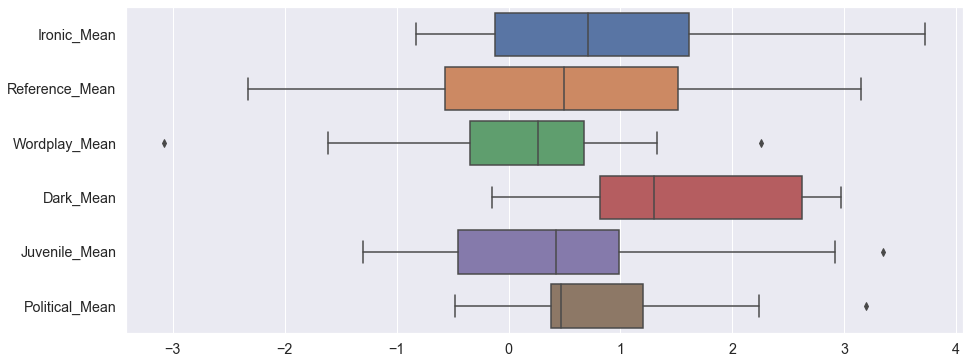

In [41]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))  ##height, width
sb.boxplot(data = boxplot_df, orient = "h")

> Ironic Category have the highest maximum rating (3.72) while Wordplay have the minimum rating (-3.08).  
Dark Category have both the largest mean (1.57) and median (1.30).


## #4.3: Jointplot + Heatmap -> Whether the Length of Jokes affects the Ratings

In [42]:
joke_catmean['Text_forLength']= joke_catmean['JokeText']
#remove all punctuation and change all to lower case
joke_catmean['Text_forLength'] = joke_catmean['Text_forLength'].str.replace('[^\w\s]',' ').str.lower()

In [43]:
joke_catmean['Letter_Length'] = joke_catmean['Text_forLength'].str.len()

In [44]:
mean_length_df = joke_catmean[['Mean', 'Letter_Length']]

In [45]:
#Sample of the mean and length dataframe created
mean_length_df.head()

Mean  Letter_Length
0  0.618628            163
1  0.144385            383
2  0.189761             88
3 -0.908733            111
4  0.333205             95

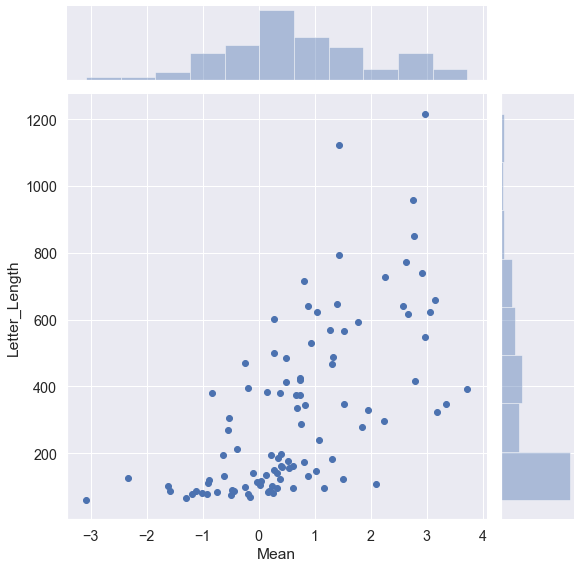

In [46]:
sb.jointplot(x='Mean',y='Letter_Length', data=mean_length_df, height = 8)

In [47]:
# Calculate the correlation between the two columns/variables
mean_length_df.corr()

Mean  Letter_Length
Mean           1.000000       0.636216
Letter_Length  0.636216       1.000000

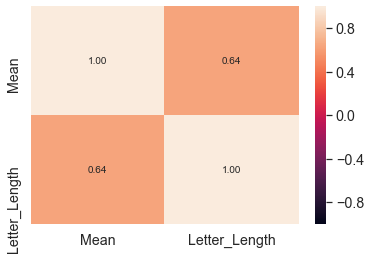

In [48]:
sb.heatmap(mean_length_df.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

> The plot and correlation table shows that there is a **positive correlation** between the Length of Jokes and Ratings.  
This means that when the jokes are longer, it's ratings will most likely be higher as compared to shorter jokes.  

**Jokes longer = more narrative description of the jokes = User can understand and relate more = Give higher ratings**

# #5. Clustering Model: Based on User Ratings

In [49]:
joker_mainDF=pd.read_csv("Cleaned Dataset-Joker.csv")
#joker_mainDF.head(100004)
joker_rating_only=joker_mainDF.drop([0, 1, 2])
#joker_rating_only.head(100004)
clustering_df=joker_rating_only.drop(['Joke Listing'], axis=1)
#clustering_df.head(100004)

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
#placeholder for elbow plot

In [51]:
#Best K is roughly at 17 
# Import essential models from sklearn
from sklearn.cluster import KMeans

# Set "optimal" Clustering Parameters
num_clust = 17
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20, random_state=0)                 

# Fit the Clustering Model on the Data
kmeans.fit(clustering_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Within Cluster Sum of Squares : 12855223.476420654



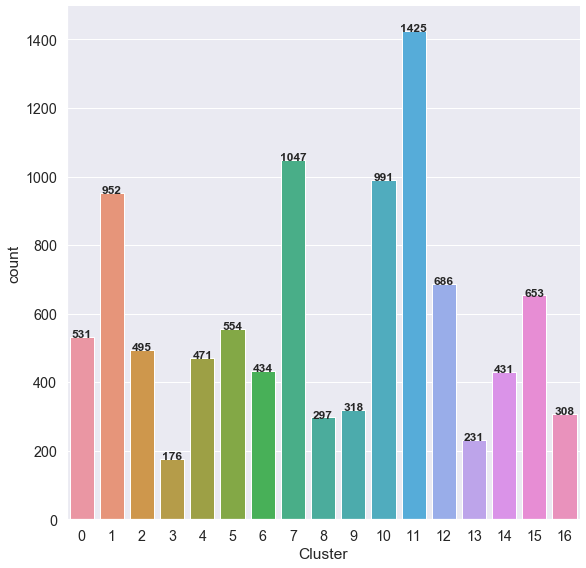

In [52]:
# Not Printing the Cluster Centers since we making it to csv file
#print("\tCluster 1", "\tCluster 2", "\tCluster 3", "\Cluster 1")
#print()

#count=1
#for i, center in enumerate(kmeans.cluster_centers_):
#    print("\nCluster", i, end=":\t")
#    count=1
#    for coord in center:
#        print("     Joke "+str(count) + ": "+str(round(coord, 2)), end="\t")
#        count=count+1
#    print()
#print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(clustering_df)

# Append Labels to the Data
clustered_ready = clustering_df.copy()
clustering = clustering_df.copy()
clustering["Cluster"] = pd.Categorical(labels)
clustered_ready.insert(0, 'Cluster',clustering['Cluster'])
#clustered_ready.head()

# Summary of the Cluster Labels + Convert to csv file for better viewing
plot = sb.catplot(x = "Cluster", data = clustered_ready, kind = "count", height = 8)
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)
    
clustered_ready.to_csv('Cluster Ready.csv', index = False)

> For better viewing of the Clusters we have created a 'Cluster Ready.csv.   
>   The plot shows the **count of users in each clusters**.

## Preparing all the cluster dataframe, reindex to start them from *1*

the row number indicates the User ID so starts from 1 

In [53]:
clustered_ready=pd.read_csv("Cluster Ready.csv")
clustered_ready.index = np.arange(1, len(clustered_ready) + 1) #starts from 1 

In [54]:
cluster0_df=clustered_ready.loc[clustered_ready['Cluster'] == 0]
cluster0_df = cluster0_df.iloc[:,1:] #w/o cluster group name

cluster1_df=clustered_ready.loc[clustered_ready['Cluster'] == 1]
cluster1_df=cluster1_df.iloc[:,1:]

cluster2_df=clustered_ready.loc[clustered_ready['Cluster'] == 2]
cluster2_df=cluster2_df.iloc[:,1:]

cluster3_df=clustered_ready.loc[clustered_ready['Cluster'] == 3]
cluster3_df=cluster3_df.iloc[:,1:]


cluster4_df=clustered_ready.loc[clustered_ready['Cluster'] == 4]
cluster4_df=cluster4_df.iloc[:,1:]


cluster5_df=clustered_ready.loc[clustered_ready['Cluster'] == 5]
cluster5_df=cluster5_df.iloc[:,1:]


cluster6_df=clustered_ready.loc[clustered_ready['Cluster'] == 6]
cluster6_df=cluster6_df.iloc[:,1:]


cluster7_df=clustered_ready.loc[clustered_ready['Cluster'] == 7]
cluster7_df=cluster7_df.iloc[:,1:]


cluster8_df=clustered_ready.loc[clustered_ready['Cluster'] == 8]
cluster8_df=cluster8_df.iloc[:,1:]


cluster9_df=clustered_ready.loc[clustered_ready['Cluster'] == 9]
cluster9_df=cluster9_df.iloc[:,1:]


cluster10_df=clustered_ready.loc[clustered_ready['Cluster'] == 10]
cluster10_df=cluster10_df.iloc[:,1:]


cluster11_df=clustered_ready.loc[clustered_ready['Cluster'] == 11]
cluster11_df=cluster11_df.iloc[:,1:]


cluster12_df=clustered_ready.loc[clustered_ready['Cluster'] == 12]
cluster12_df=cluster12_df.iloc[:,1:]


cluster13_df=clustered_ready.loc[clustered_ready['Cluster'] == 13]
cluster13_df=cluster13_df.iloc[:,1:]


cluster14_df=clustered_ready.loc[clustered_ready['Cluster'] == 14]
cluster14_df=cluster14_df.iloc[:,1:]


cluster15_df=clustered_ready.loc[clustered_ready['Cluster'] == 15]
cluster15_df=cluster15_df.iloc[:,1:]


cluster16_df=clustered_ready.loc[clustered_ready['Cluster'] == 16]
cluster16_df=cluster16_df.iloc[:,1:]

## Heatmap for All Clusters

#### To understand the heatmap:  
    - Each column is a different joke [Joke 1 to Joke 100]  
    - Each row is a different user with their ID  
    - The cell's color is the rating that each user has given to each jokes. 
    - The values for each color can be checked in the scale to the right  
    - Darker color = Negative Ratings, Light color = Positive Ratings
##### Labels:
    - The User ID shown in the heatmap are only a portion of the count of users in that cluster. 
    - The Joke ID shown in the heatmap are in increment of 3.

Cluster 0 HeatMap


Text(107.5, 0.5, 'User ID')

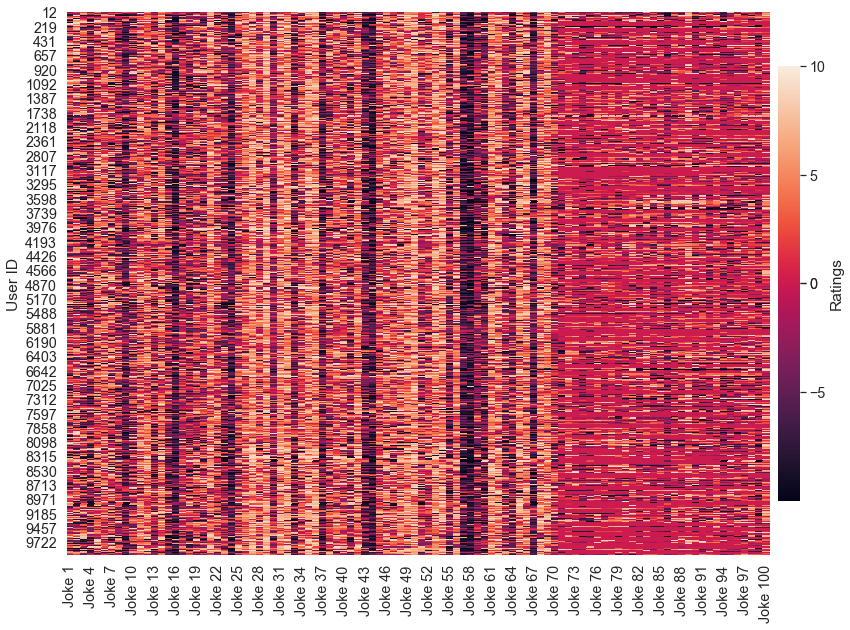

In [55]:
plt.subplots(figsize=(15,10))
print("Cluster 0 HeatMap")
ax0=sb.heatmap(cluster0_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax0.set_ylabel("User ID")

Cluster 1 HeatMap


Text(107.5, 0.5, 'User ID')

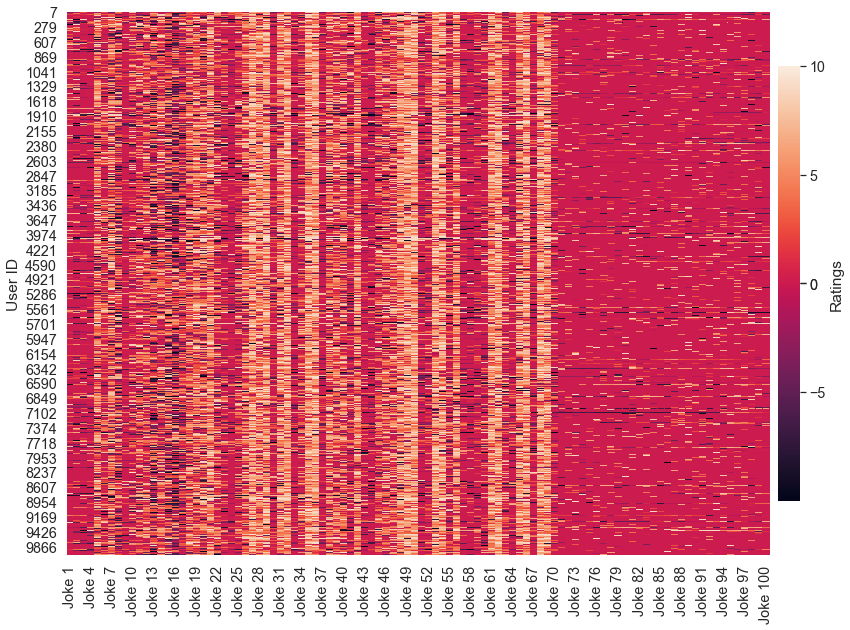

In [56]:
plt.subplots(figsize=(15,10))
print("Cluster 1 HeatMap")
ax1=sb.heatmap(cluster1_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax1.set_ylabel("User ID")

Cluster 2 HeatMap


Text(107.5, 0.5, 'User ID')

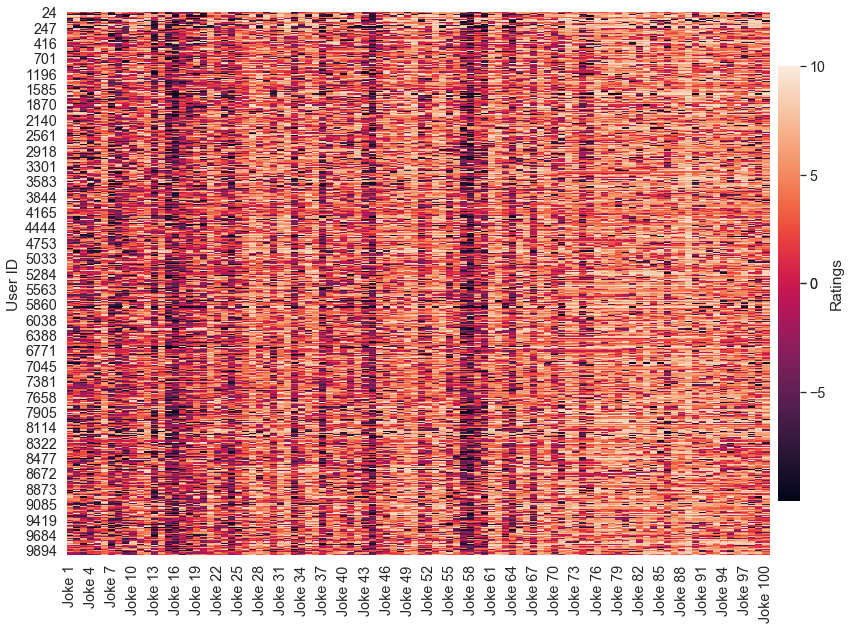

In [57]:
plt.subplots(figsize=(15,10))
print("Cluster 2 HeatMap")
ax2=sb.heatmap(cluster2_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax2.set_ylabel("User ID")

Cluster 3 HeatMap


Text(107.5, 0.5, 'User ID')

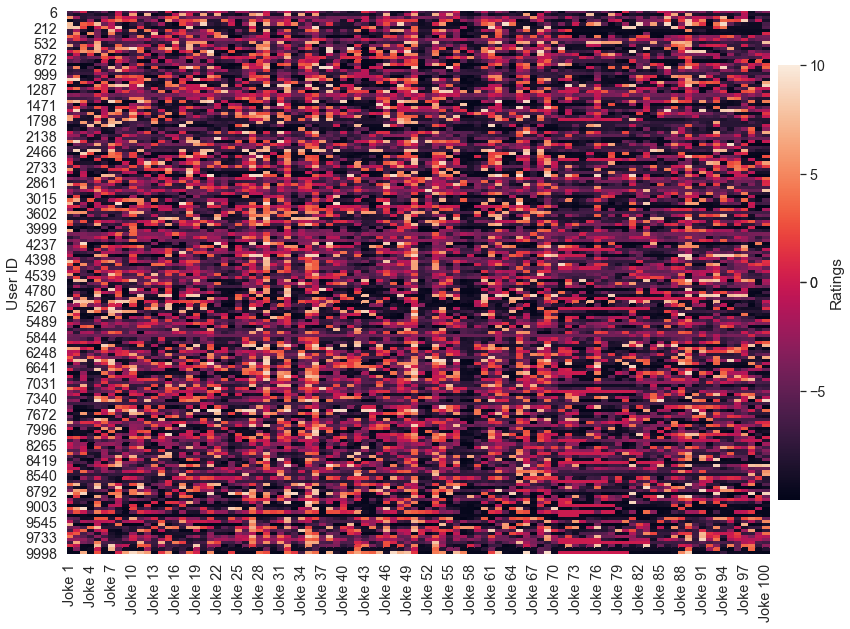

In [58]:
plt.subplots(figsize=(15,10))
print("Cluster 3 HeatMap")
ax3=sb.heatmap(cluster3_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax3.set_ylabel("User ID")

Cluster 4 HeatMap


Text(107.5, 0.5, 'User ID')

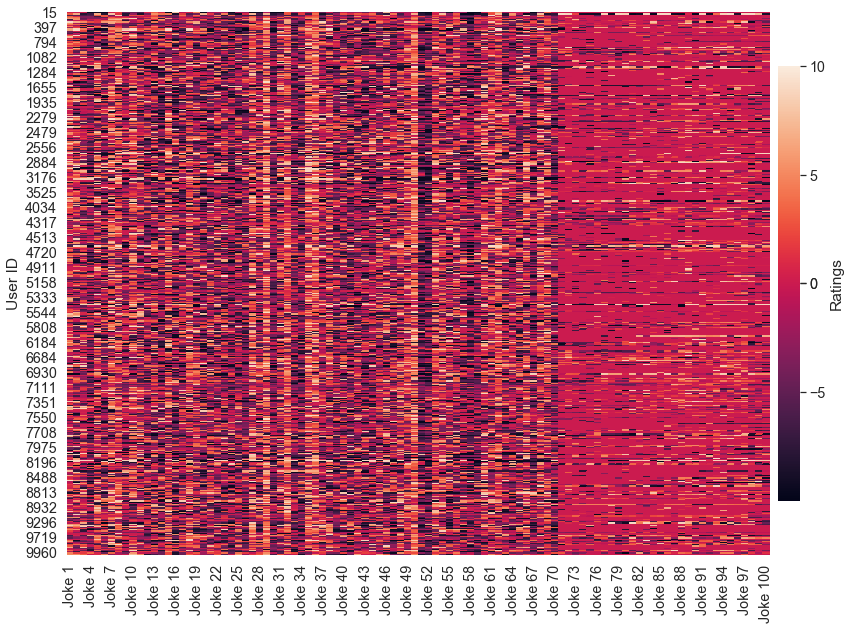

In [59]:
plt.subplots(figsize=(15,10))
print("Cluster 4 HeatMap")
ax4=sb.heatmap(cluster4_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax4.set_ylabel("User ID")

Cluster 5 HeatMap


Text(107.5, 0.5, 'User ID')

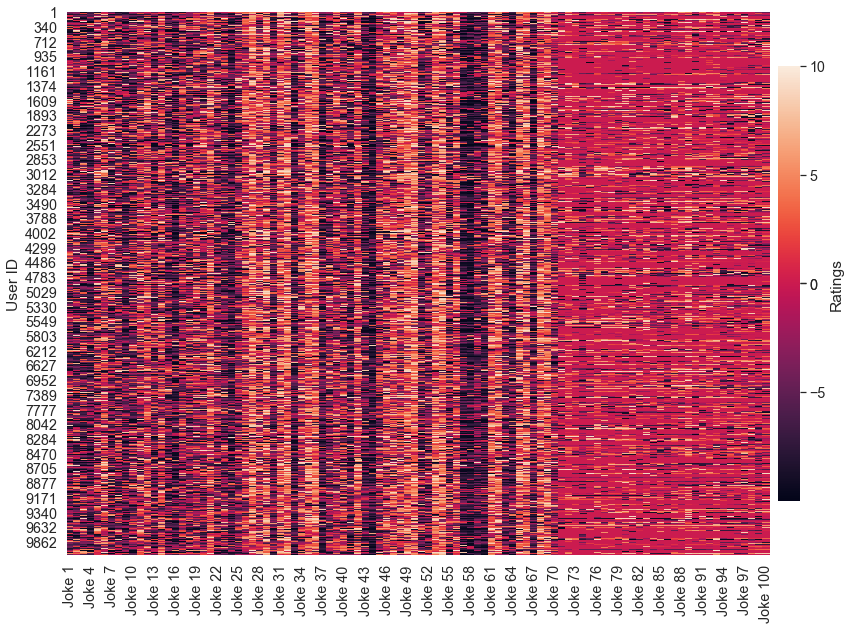

In [60]:
plt.subplots(figsize=(15,10))
print("Cluster 5 HeatMap")
ax5=sb.heatmap(cluster5_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax5.set_ylabel("User ID")

Cluster 6 HeatMap


Text(107.5, 0.5, 'User ID')

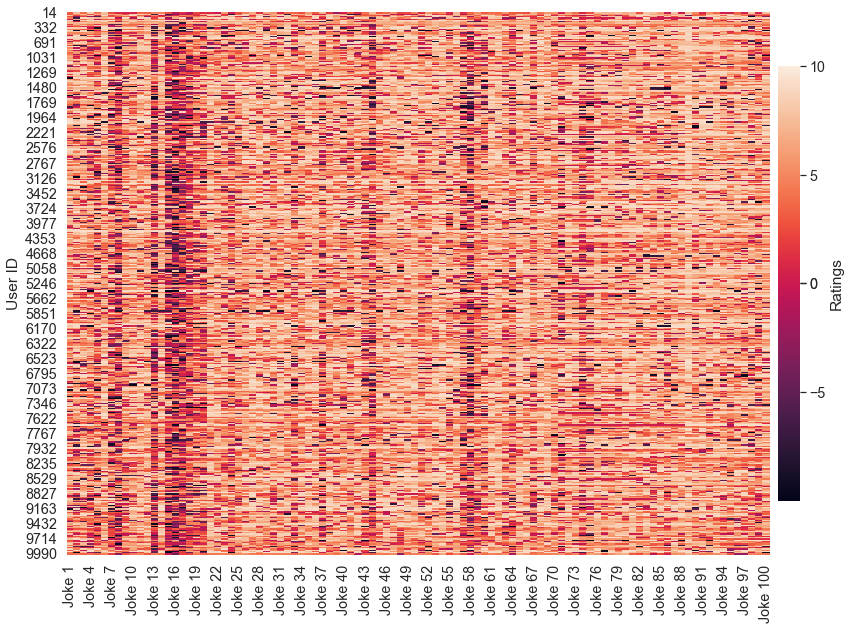

In [61]:
plt.subplots(figsize=(15,10))
print("Cluster 6 HeatMap")
ax6=sb.heatmap(cluster6_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax6.set_ylabel("User ID")

Cluster 7 HeatMap


Text(107.5, 0.5, 'User ID')

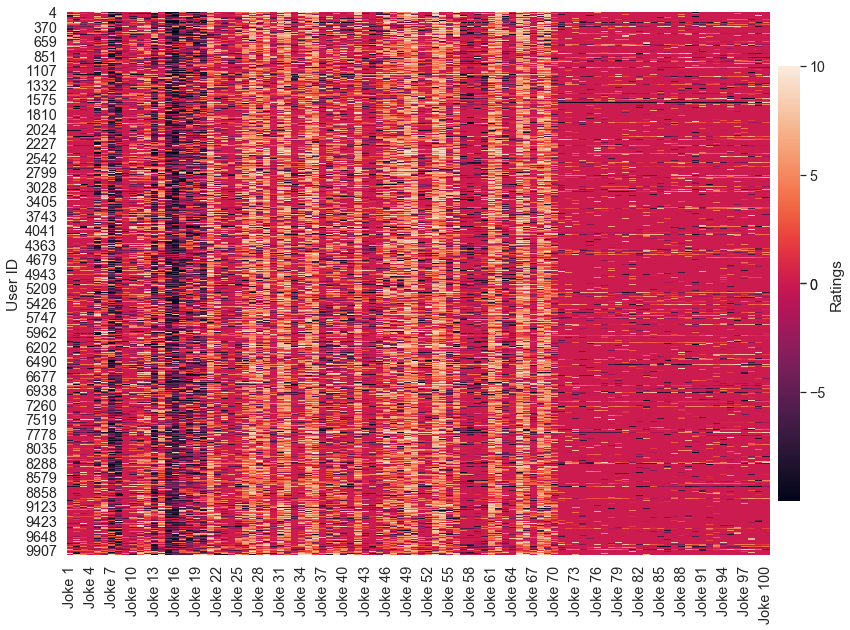

In [62]:
plt.subplots(figsize=(15,10))
print("Cluster 7 HeatMap")
ax7=sb.heatmap(cluster7_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax7.set_ylabel("User ID")

Cluster 8 HeatMap


Text(107.5, 0.5, 'User ID')

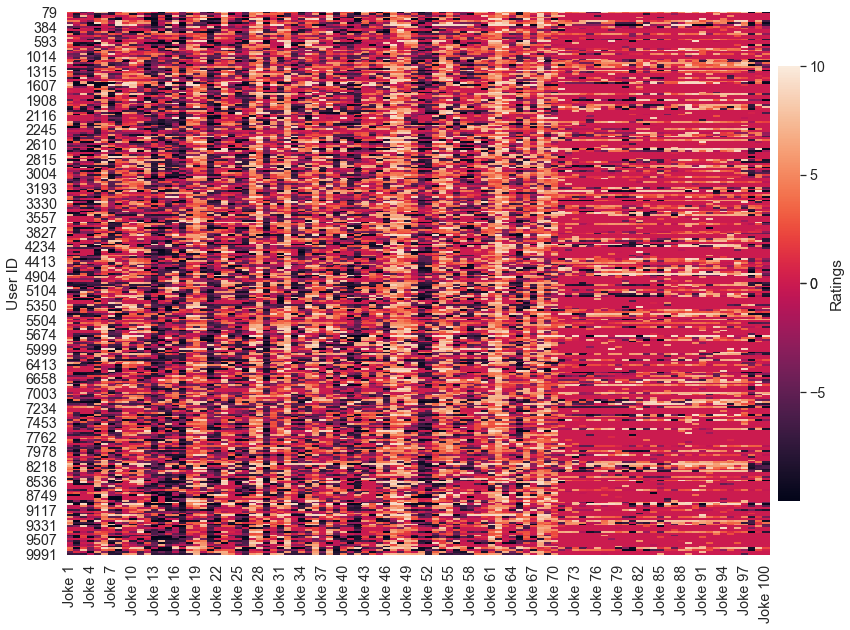

In [63]:
plt.subplots(figsize=(15,10))
print("Cluster 8 HeatMap")
ax8=sb.heatmap(cluster8_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax8.set_ylabel("User ID")

Cluster 9 HeatMap


Text(107.5, 0.5, 'User ID')

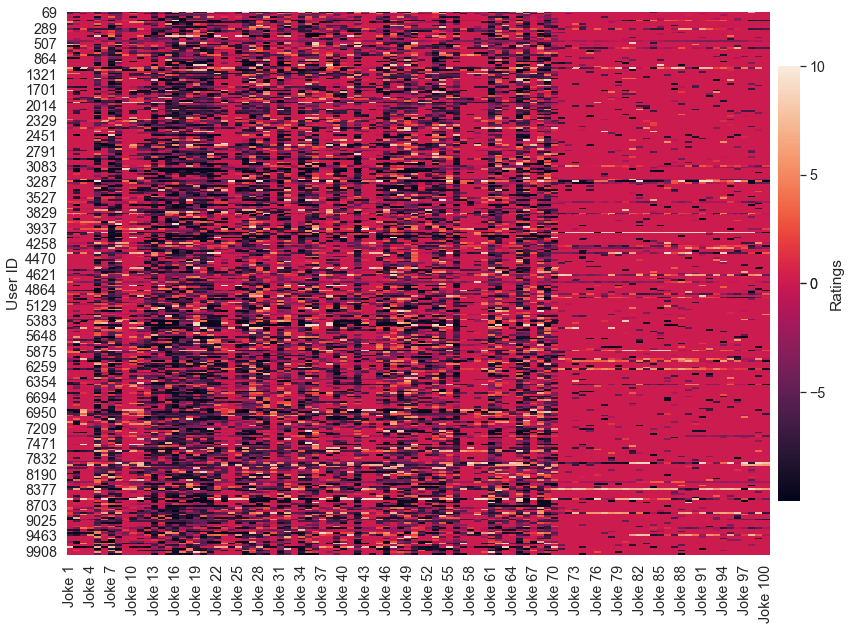

In [64]:
plt.subplots(figsize=(15,10))
print("Cluster 9 HeatMap")
ax9=sb.heatmap(cluster9_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax9.set_ylabel("User ID")

Cluster 10 HeatMap


Text(107.5, 0.5, 'User ID')

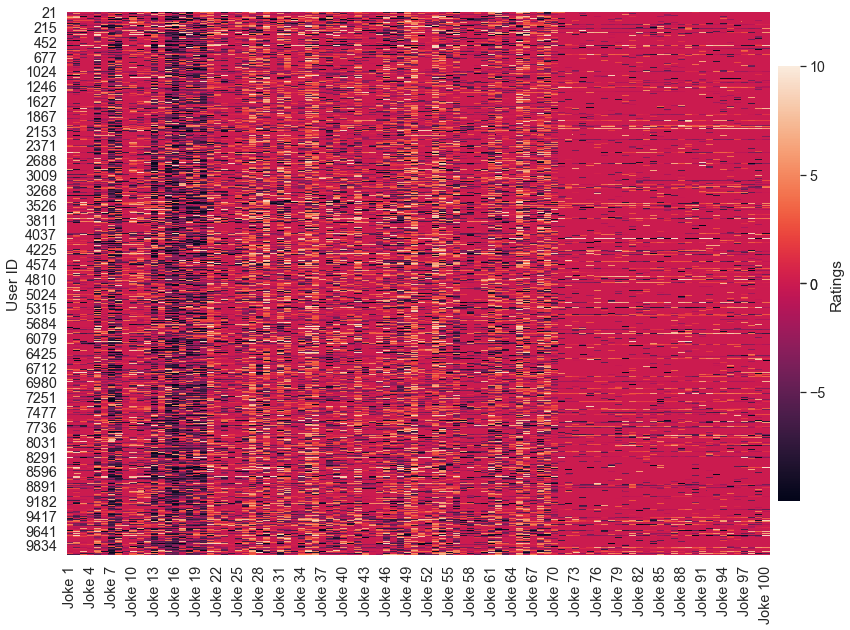

In [65]:
plt.subplots(figsize=(15,10))
print("Cluster 10 HeatMap")
ax10=sb.heatmap(cluster10_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax10.set_ylabel("User ID")

Cluster 11 HeatMap


Text(107.5, 0.5, 'User ID')

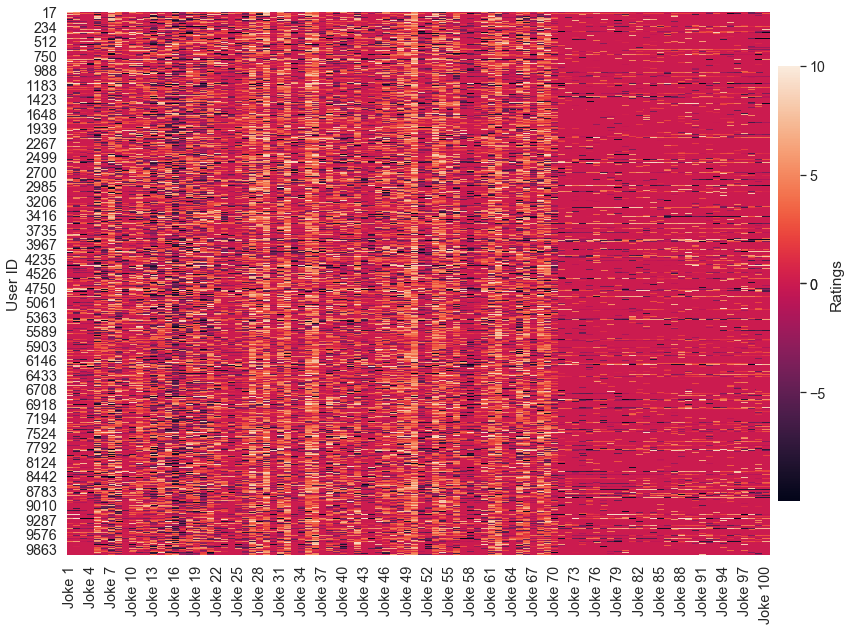

In [66]:
plt.subplots(figsize=(15,10))
print("Cluster 11 HeatMap")
ax11=sb.heatmap(cluster11_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax11.set_ylabel("User ID")

Cluster 12 HeatMap


Text(107.5, 0.5, 'User ID')

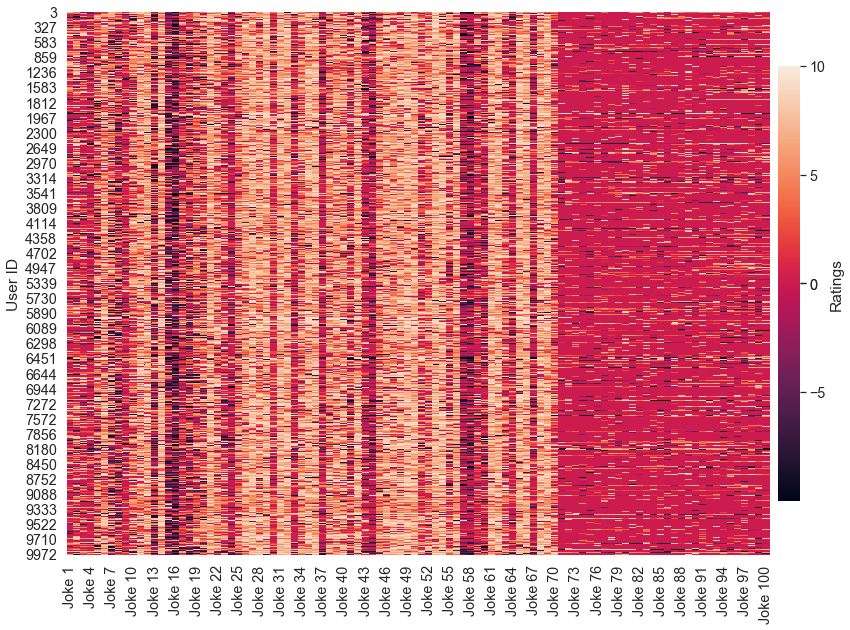

In [67]:
plt.subplots(figsize=(15,10))
print("Cluster 12 HeatMap")
ax12=sb.heatmap(cluster12_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax12.set_ylabel("User ID")

Cluster 13 HeatMap


Text(107.5, 0.5, 'User ID')

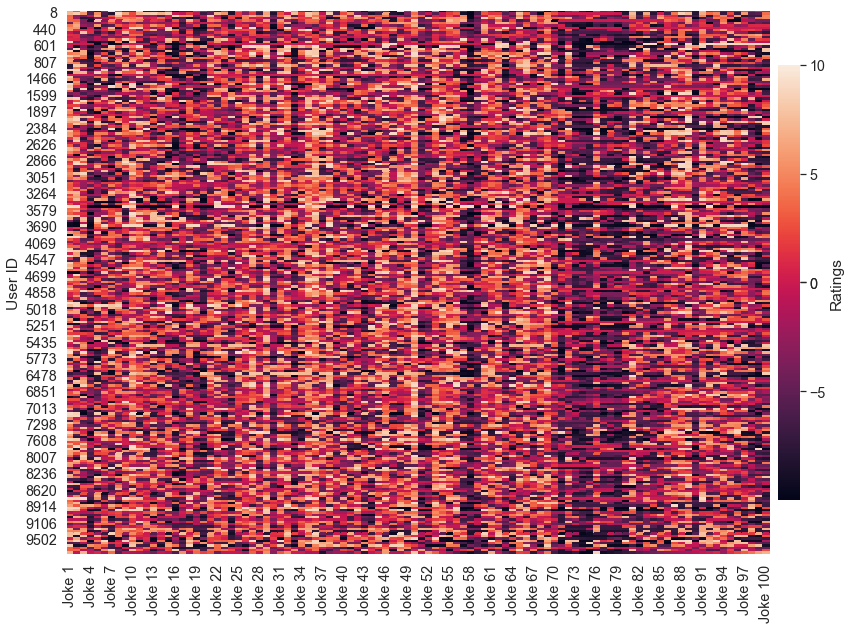

In [68]:
plt.subplots(figsize=(15,10))
print("Cluster 13 HeatMap")
ax13=sb.heatmap(cluster13_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax13.set_ylabel("User ID")

Cluster 14 HeatMap


Text(107.5, 0.5, 'User ID')

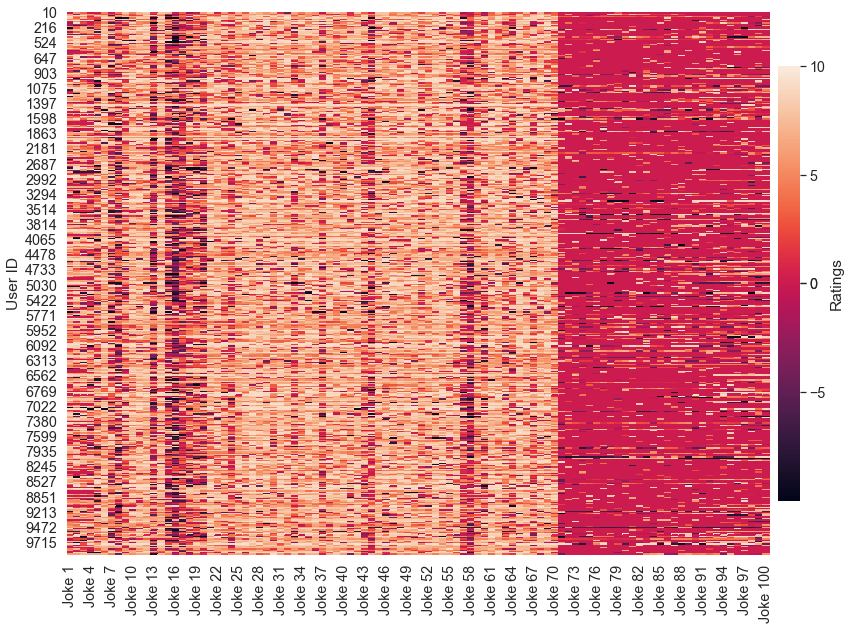

In [69]:
plt.subplots(figsize=(15,10))
print("Cluster 14 HeatMap")
ax14=sb.heatmap(cluster14_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax14.set_ylabel("User ID")

Cluster 15 HeatMap


Text(107.5, 0.5, 'User ID')

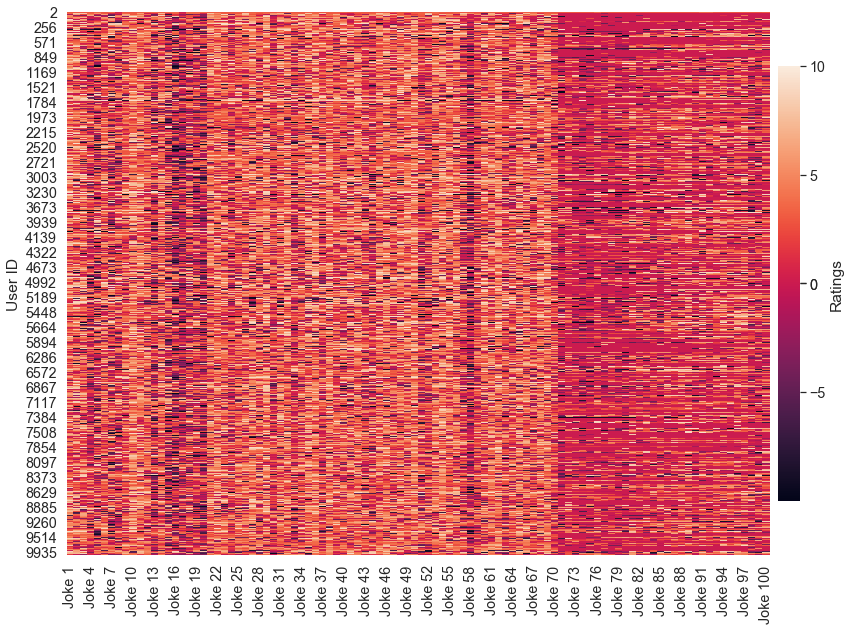

In [70]:
plt.subplots(figsize=(15,10))
print("Cluster 15 HeatMap")
ax15=sb.heatmap(cluster15_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax15.set_ylabel("User ID")

Cluster 16 HeatMap


Text(107.5, 0.5, 'User ID')

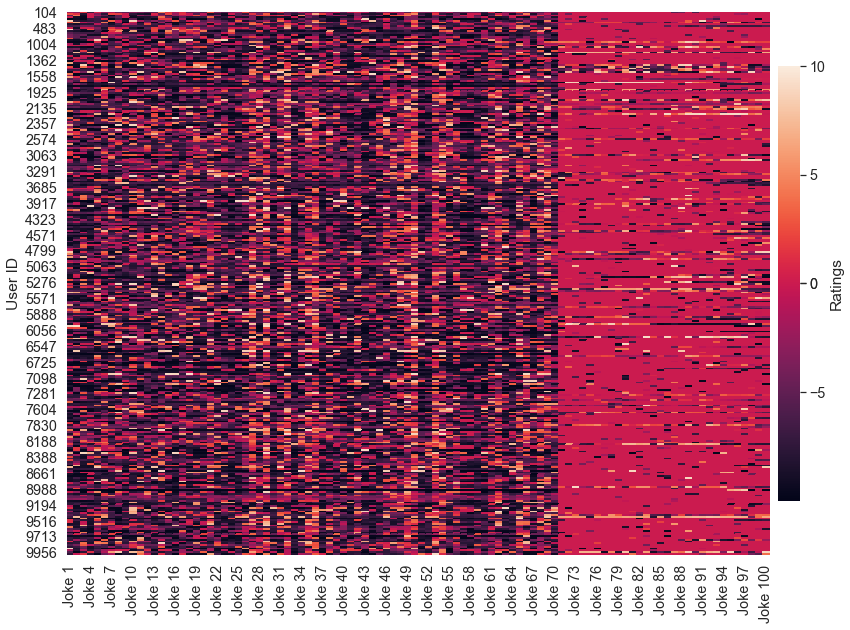

In [71]:
plt.subplots(figsize=(15,10))
print("Cluster 16 HeatMap")
ax16=sb.heatmap(cluster16_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax16.set_ylabel("User ID")

#### Quick Analysis on all the heatmaps 's colors: Contrasting views in each clusters
    Generally Mixed Ratings - 0, 1, 7, 8, 13, 15
    Generally Negative Ratings - 3, 4, 5, 9, 10, 11, 16
    Generally Positive Ratings - 2, 6, 12, 14

# #6. Analysis on Cluster1 and Cluster 10

### Why Cluster 1 and 10?
With reference to #5. Clustering Model's catplot, they both have similar number of users.  
Cluster 1 -> 952 , Cluster 10 -> 991  

#### Steps :
    1. Analysis Heat Map
    2. Find out the type of jokes users like:
    - by creating a new dataframe to show Positive , Negative and Net count of the ratings that the user rated (Catplot)
    - determine categories that the users in that cluster like and dislike.
    
    3. Analysis the ratings of those categories choosen in *Step 2* (Boxplot)
    
### Consolidated Analysis can be found at  #6.1.4  Cluster 1 and #6.2.4 Cluster 10.
### Conclusion can be found at #7.

## #6.1.1  Cluster 1: HeatMap

Cluster 1 HeatMap


Text(107.5, 0.5, 'User ID')

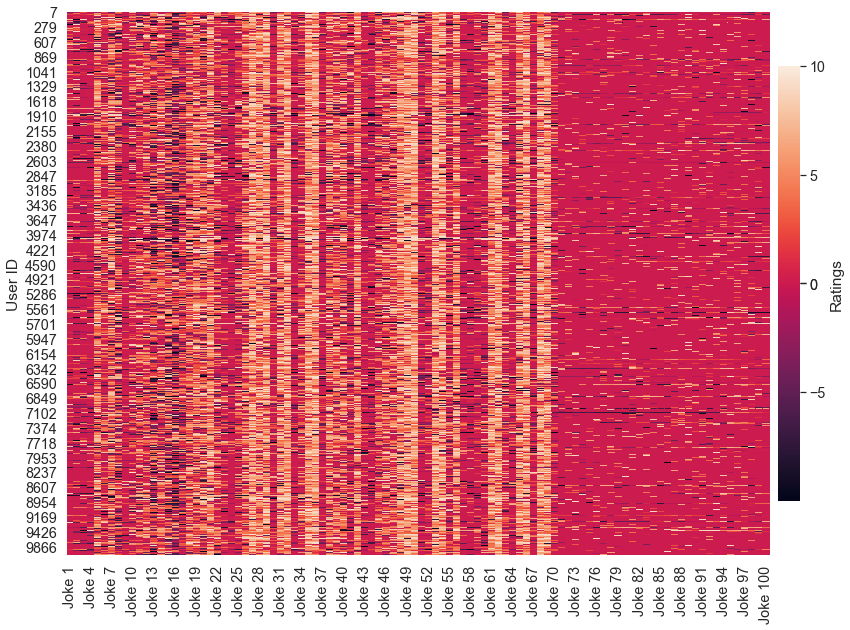

In [72]:
#heatmap
plt.subplots(figsize=(15,10))
print("Cluster 1 HeatMap")
ax1=sb.heatmap(cluster1_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax1.set_ylabel("User ID")

## #6.1.2 Cluster 1: Catplot based on Negative/Positive + Net Ratings

In [73]:
#Cluster 1
jokeList = dict.fromkeys({"Jokes","Positive","Negative","Net Rating"})
tempList = []
positiveList = []
negativeList = []
netRatingList = []

for jokes in cluster1_df:
    positive = 0
    negative = 0
    tempList.append(str(jokes))
    for rating in cluster1_df[jokes]:
        if(rating>0):
            positive+=1
        elif(rating<0):
            negative+=1
    positiveList.append(positive)
    negativeList.append(negative)
    netRatingList.append(positive-negative)

In [74]:
##rerun this if got error
jokeTypeList = []
jokeType = joker_mainDF.transpose()[1]
jokeType = jokeType.drop(jokeType.index[0])
for t in jokeType:
    jokeTypeList.append(t)

#creating a new datframe
jokeList["Jokes"] = tempList
jokeList["Joke Type"] = jokeTypeList
jokeList["Positive"] = positiveList
jokeList["Negative"] = negativeList
jokeList["Net Rating"] = netRatingList
jokeList1_df = pd.DataFrame(jokeList)
jokePos1_df = jokeList1_df[["Jokes","Joke Type","Positive"]]
jokeNeg1_df = jokeList1_df[["Jokes","Joke Type","Negative"]]
jokeNet1_df = jokeList1_df[["Jokes","Joke Type","Net Rating"]]

In [75]:
#view dataframe
pd.set_option('display.max_rows',100)
jokeList1_df[["Jokes","Joke Type","Positive","Negative","Net Rating"]].head()

Jokes  Joke Type  Positive  Negative  Net Rating
0  Joke 1     Ironic       192        82         110
1  Joke 2       Dark       188       152          36
2  Joke 3  Reference       146       146           0
3  Joke 4  Reference       117       149         -32
4  Joke 5   Wordplay       747       202         545

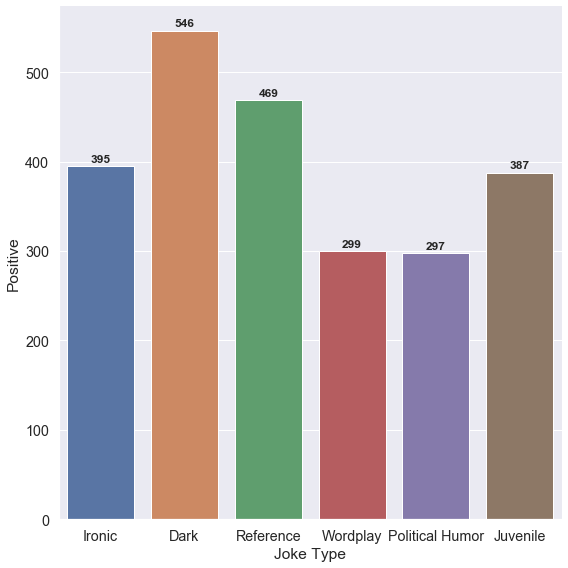

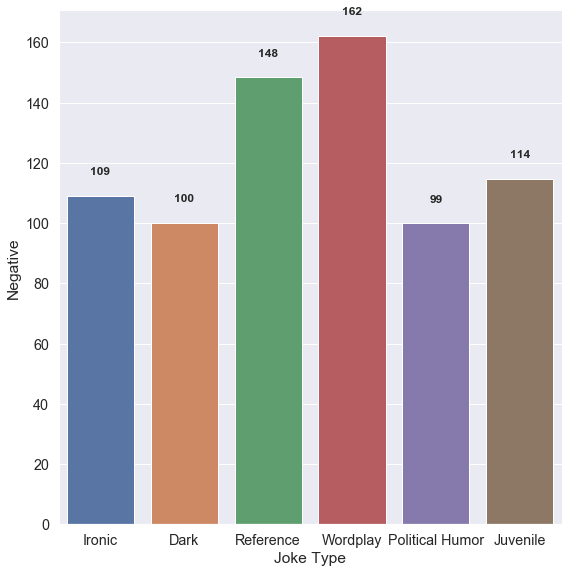

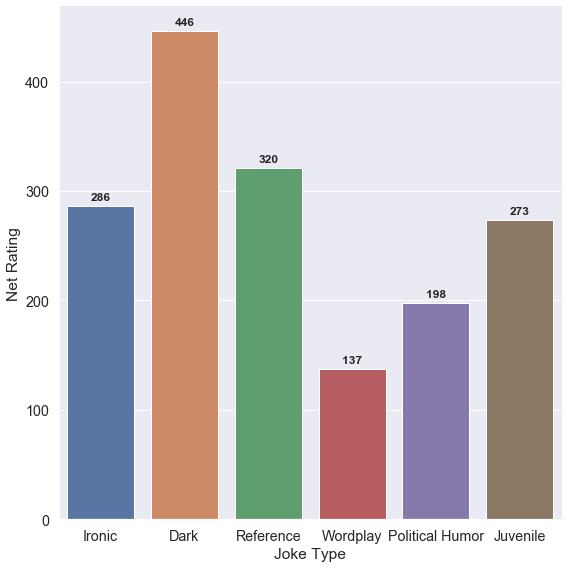

In [76]:
pos_plot = sb.catplot(y = "Positive",x="Joke Type", data = jokePos1_df, kind = "bar", height = 8, ci=None)
for i, bar in enumerate(pos_plot.ax.patches):
    h = bar.get_height()
    pos_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)
    
neg_plot = sb.catplot(y = "Negative",x="Joke Type", data = jokeNeg1_df, kind = "bar", height = 8, ci=None)
for i, bar in enumerate(neg_plot.ax.patches):
    h = bar.get_height()
    neg_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)
    
net_plot = sb.catplot(y = "Net Rating",x="Joke Type", data = jokeNet1_df, kind = "bar", height = 8, ci=None)
for i, bar in enumerate(net_plot.ax.patches):
    h = bar.get_height()
    net_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)

> Based on the catplot, the most no. of Positive ratings is Reference and Dark jokes while the most no. of Negative ratings is Wordplay jokes

#### Legend for the Catplot: Ratings Range ( 10 to -10 )
Positive = No. of Users that gave that joke type positive ratings.  
Negative =  No. of Users that gave that joke type negative ratings.  
Net Ratings = Difference between No. of Users that rate positively and negatively.  
e.g. The lower the Net Ratings = The no. of Users that rate negatively is relatively more than the other type.  
e.g. Negative value of Net Ratings = The no. of Users that rate that type of joke negatively is more than what the Users that rated positively.  
(Net dislike of the joke)  

#### From this, we can deduce that:
* 546/952 (~ 57%) users in this cluster give dark category jokes a positive rating
* 469/952 (~ 49%) Users in this cluster give Reference category jokes a Positive rating
* 162/952 (~ 17%) users in this cluster give wordplay category jokes a negative rating
* Majority of the users like dark and reference joke
* Wordplay jokes are not as well like as compared to dark and reference joke

## #6.1.3 Cluster 1: Dataframe & Table based on Type of Jokes

##### 'Most-liked and Least-liked'
- Mean Ratings of the most-liked jokes (Reference and Dark)
- Mean Ratings of the least-liked jokes (Wordplay)

In [77]:
#Dataframes for category
jokes_category=pd.read_excel("data reference/JokeText_Category.xlsx")
jokes_category.set_index("Type_of_Jokes", inplace=True)

Ironic_df= jokes_category.loc['Ironic']
Ironic_list = Ironic_df['JokeId'].values.tolist()

Reference_df= jokes_category.loc['Reference']
Reference_list = Reference_df['JokeId'].values.tolist()

Wordplay_df= jokes_category.loc['Wordplay']
Wordplay_list = Wordplay_df['JokeId'].values.tolist()

Dark_df= jokes_category.loc['Dark']
Dark_list = Dark_df['JokeId'].values.tolist()

Juvenile_df= jokes_category.loc['Juvenile']
Juvenile_list = Juvenile_df['JokeId'].values.tolist()

Political_df= jokes_category.loc['Political Humor']
Political_list = Political_df['JokeId'].values.tolist()

In [78]:
#Cluster 1 Category:
cluster1_Ironic = cluster1_df.iloc[:,Ironic_list]
cluster1_Reference = cluster1_df.iloc[:,Reference_list]
cluster1_Wordplay = cluster1_df.iloc[:,Wordplay_list]
cluster1_Dark = cluster1_df.iloc[:,Dark_list]
cluster1_Juvenile = cluster1_df.iloc[:,Juvenile_list]
cluster1_Political = cluster1_df.iloc[:,Political_list]

In [79]:
cluster1_Reference.describe()

Joke 3      Joke 4      Joke 7     Joke 11     Joke 12     Joke 15  \
count  952.000000  952.000000  952.000000  952.000000  952.000000  952.000000   
mean    -0.012857   -0.205347    2.416712    1.689937    2.011880    0.253582   
std      2.629013    2.333967    4.550138    3.795431    3.520696    4.776649   
min     -9.900000   -9.900000   -9.900000   -9.810000   -9.900000   -9.950000   
25%      0.000000    0.000000   -0.240000    0.000000    0.000000   -3.400000   
50%      0.000000    0.000000    3.180000    0.510000    1.460000    0.850000   
75%      0.000000    0.000000    5.870000    4.332500    4.760000    3.880000   
max      9.080000    8.880000    9.370000    9.320000    9.370000    9.320000   

          Joke 17     Joke 20     Joke 21     Joke 28  ...     Joke 54  \
count  952.000000  952.000000  952.000000  952.000000  ...  952.000000   
mean     0.318981    2.128876    4.185788    4.019800  ...    4.654475   
std      3.815397    4.330760    3.550598    3.485204  ...    3.605357   
min     -9.850000   -9.900000   -9.470000   -9.810000  ...   -9.810000   
25%     -1.952500   -0.490000    2.280000    1.877500  ...    2.480000   
50%      0.580000    2.645000    4.760000    4.510000  ...    5.390000   
75%      2.830000    5.390000    6.840000    6.712500  ...    7.430000   
max      9.370000    9.370000    9.370000    9.320000  ...    9.320000   

          Joke 55     Joke 57     Joke 58     Joke 68     Joke 82     Joke 83  \
count  952.000000  952.000000  952.000000  952.000000  952.000000  952.000000   
mean     0.685357   -0.152321   -0.520126    5.061113    0.194664    0.157679   
std      3.363304    2.700161    2.695700    3.386273    1.633183    1.835412   
min     -9.950000   -9.900000   -9.850000   -9.900000   -8.450000   -9.220000   
25%      0.000000    0.000000    0.000000    3.450000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    5.805000    0.000000    0.000000   
75%      2.330000    0.000000    0.000000    7.532500    0.000000    0.000000   
max      9.320000    9.170000    8.930000    9.370000    9.270000    9.030000   

          Joke 84     Joke 90     Joke 92  
count  952.000000  952.000000  952.000000  
mean     0.140725    0.172363    0.299065  
std      1.750319    1.756266    1.948952  
min     -9.900000   -9.510000   -9.320000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
max      9.030000    9.270000    9.320000  

[8 rows x 27 columns]

> Count : 952 Users in Cluster 1  
> Joke 3 , 4 ,7 , 11, 12 ... in Reference Category

### Making Dataframe and Boxplot for Dark, Reference and Wordplay Jokes

In [80]:
##Using each jokes in the category mean as one value
c1_Reference_mean = cluster1_Reference.mean().to_frame()
c1_Dark_mean = cluster1_Dark.mean().to_frame()
c1_Wordplay_mean = cluster1_Wordplay.mean().to_frame()

##Reference Joke: each Joke ID have mean value as 'final' ratings for that joke
c1_Reference_mean.head()

0
Joke 3  -0.012857
Joke 4  -0.205347
Joke 7   2.416712
Joke 11  1.689937
Joke 12  2.011880

In [81]:
c1_boxplot = pd.concat([c1_Reference_mean.rename(columns={ c1_Reference_mean.columns[0]: "Cluster1_Reference_Mean" })
, c1_Dark_mean.rename(columns={ c1_Dark_mean.columns[0]: "Cluster1_Dark_Mean" }), c1_Wordplay_mean.rename(columns={c1_Wordplay_mean.columns[0]: "Cluster1_Wordplay_Mean" })], axis=1, sort = True)

##### Statistical Description of Reference, Dark and Wordplay Jokes

In [82]:
c1_boxplot.describe().round(2)

Cluster1_Reference_Mean  Cluster1_Dark_Mean  Cluster1_Wordplay_Mean
count                    27.00               13.00                   27.00
mean                      1.83                2.68                    0.69
std                       1.95                2.21                    1.11
min                      -0.52                0.05                   -0.96
25%                       0.17                0.38                    0.04
50%                       1.69                2.81                    0.25
75%                       3.16                4.72                    1.22
max                       5.47                5.37                    3.78

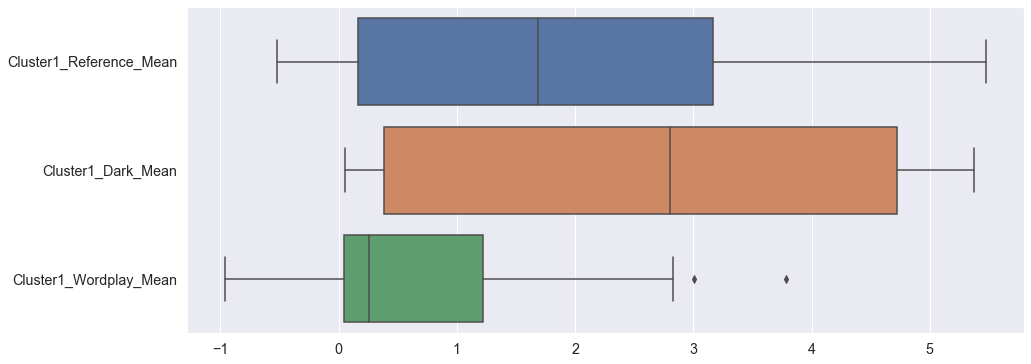

In [83]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))  ##height, width
sb.boxplot(data = c1_boxplot, orient = "h")

##### Short Description of the Boxplot:

In [84]:
print('Reference Category: Maximum Rating of %.2f is derived from %s and Minimum Rating of %.2f is derived from %s.'%(c1_boxplot["Cluster1_Reference_Mean"].max(),c1_boxplot["Cluster1_Reference_Mean"].idxmax(axis = 0),c1_boxplot["Cluster1_Reference_Mean"].min(),c1_boxplot["Cluster1_Reference_Mean"].idxmin(axis = 0)))
print('Dark Category Maximum rating of %.2f is derived from %s and Minimum Rating of %.2f is derived from %s.'%(c1_boxplot["Cluster1_Dark_Mean"].max(),c1_boxplot["Cluster1_Dark_Mean"].idxmax(axis = 0),c1_boxplot["Cluster1_Dark_Mean"].min(),c1_boxplot["Cluster1_Dark_Mean"].idxmin(axis = 0)))
print('Wordplay Category Maximum rating of %.2f is derived from %s and Minimum Rating of %.2f is derived from %s.'%(c1_boxplot["Cluster1_Wordplay_Mean"].max(),c1_boxplot["Cluster1_Wordplay_Mean"].idxmax(axis = 0),c1_boxplot["Cluster1_Wordplay_Mean"].min(),c1_boxplot["Cluster1_Wordplay_Mean"].idxmin(axis = 0)))

Reference Category: Maximum Rating of 5.47 is derived from Joke 32 and Minimum Rating of -0.52 is derived from Joke 58.
Dark Category Maximum rating of 5.37 is derived from Joke 35 and Minimum Rating of 0.05 is derived from Joke 2.
Wordplay Category Maximum rating of 3.78 is derived from Joke 65 and Minimum Rating of -0.96 is derived from Joke 16.


>  Inside Cluster 1: Reference and Dark are the most-liked jokes while Wordplay are the least-liked jokes.

## #6.1.4 Consolidated Analysis Based on Cluster 1:
From the heatmap:

we can see generally that Majority of the users in this cluster:

    *Jokes 70 - 99 have neutral feeling for them (red in colour)*
    *Jokes 27,29,33,35,57,49,51,61,63,67,69 are generally well-liked (orange in colour)*
    *Jokes 13-17 are not well-liked by the users (dark purple)*

From Catplot on Positive and Negative Value:
The count shows that users in cluster 1 like jokes that are in Dark and Reference category (Most No. of count of Postive Value) and they dislike jokes from Wordplay (Most No. of count of Negative Value)

From Catplot on difference between positive and negative value (Net Rating):
Majority of Users generally give all categories of joke a positive ratings

From this, we can deduce that:
* 546/952 (~ 57%) users in this cluster give dark category jokes a positive rating
* 469/952 (~ 49%) Users in this cluster give Reference category jokes a Positive rating
* 162/952 (~ 17%) users in this cluster give wordplay category jokes a negative rating
* Majority of the users like dark and reference joke
* Wordplay jokes are not as well like as compared todark and reference joke


From Boxplot of the Dark, Reference and Wordplay Category (derived from catplot previously):

Analysis into which specific type of jokes the users like: using c1_boxplot.describe()

Reference jokes :    c1_boxplot["Cluster1_Reference_Mean"].describe()
    
    Maximum Rating of 5.47 is derived from Joke 32.
    Minimum Rating of -0.52 is derived from Joke 58.
    Having a Mean of 1.83.

Dark Jokes :   c1_boxplot["Cluster1_Dark_Mean"].describe()

    Maximum rating of 5.37 is derived from Joke 35.
    Minimum Rating of 0.05 is derived from Joke 2.
    Having a Mean of 2.68.


Further analysis into which specific type of jokes the users dislike: (based on average rating)

Wordplay:   c1_boxplot["Cluster1_Wordplay_Mean"].describe()

    Maximum rating of 3.78 is derived from Joke 65.
    Minimum Rating of -0.96 is derived from Joke 16.
    Having a Mean of 0.69.


## #6.2 Cluster 10

## #6.2.1  Cluster 10: HeatMap

Cluster 10 HeatMap


Text(107.5, 0.5, 'User ID')

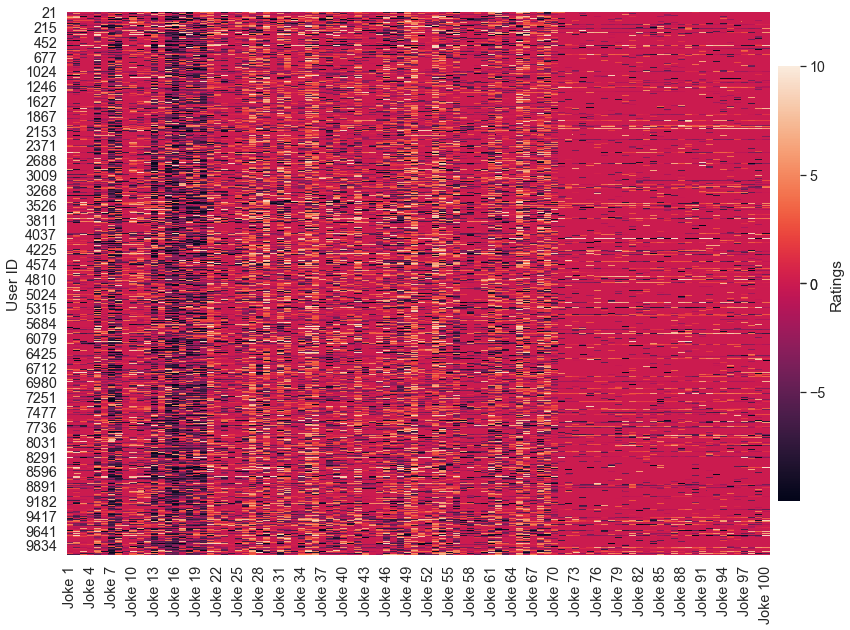

In [85]:
#heatmap
plt.subplots(figsize=(15,10))
print("Cluster 10 HeatMap")
ax1=sb.heatmap(cluster10_df, vmin=-10, vmax=10, cbar_kws={'label': 'Ratings', 'ticks': [10, 5, 0, -5, 0],'pad': 0.01, 'shrink' : 0.8})
ax1.set_ylabel("User ID")

## #6.2.2 Cluster 10: Catplot based on Negative/Positive + Net Rating

In [86]:
#Cluster 10
jokeList = dict.fromkeys({"Jokes","Positive","Negative","Net Rating"})
tempList = []
positiveList = []
negativeList = []
netRatingList = []

for jokes in cluster10_df:
    positive = 0
    negative = 0
    tempList.append(str(jokes))
    for rating in cluster10_df[jokes]:
        if(rating>0):
            positive+=1
        elif(rating<0):
            negative+=1
    positiveList.append(positive)
    negativeList.append(negative)
    netRatingList.append(positive-negative)

In [87]:
##rerun this if got error
jokeTypeList = []
jokeType = joker_mainDF.transpose()[1]
jokeType = jokeType.drop(jokeType.index[0])
for t in jokeType:
    jokeTypeList.append(t)

#creating a new datframe
jokeList["Jokes"] = tempList
jokeList["Joke Type"] = jokeTypeList
jokeList["Positive"] = positiveList
jokeList["Negative"] = negativeList
jokeList["Net Rating"] = netRatingList
jokeList10_df = pd.DataFrame(jokeList)
jokePos10_df = jokeList10_df[["Jokes","Joke Type","Positive"]]
jokeNeg10_df = jokeList10_df[["Jokes","Joke Type","Negative"]]
jokeNet10_df = jokeList10_df[["Jokes","Joke Type","Net Rating"]]

In [88]:
#view dataframe
pd.set_option('display.max_rows',100)
jokeList1_df[["Jokes","Joke Type","Positive","Negative","Net Rating"]].head()

Jokes  Joke Type  Positive  Negative  Net Rating
0  Joke 1     Ironic       192        82         110
1  Joke 2       Dark       188       152          36
2  Joke 3  Reference       146       146           0
3  Joke 4  Reference       117       149         -32
4  Joke 5   Wordplay       747       202         545

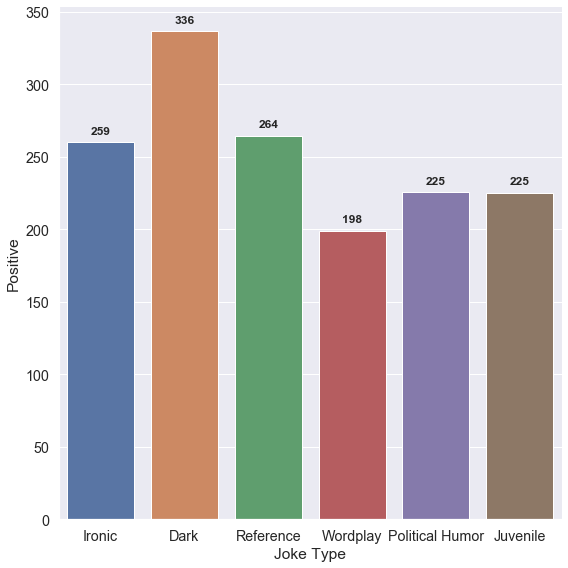

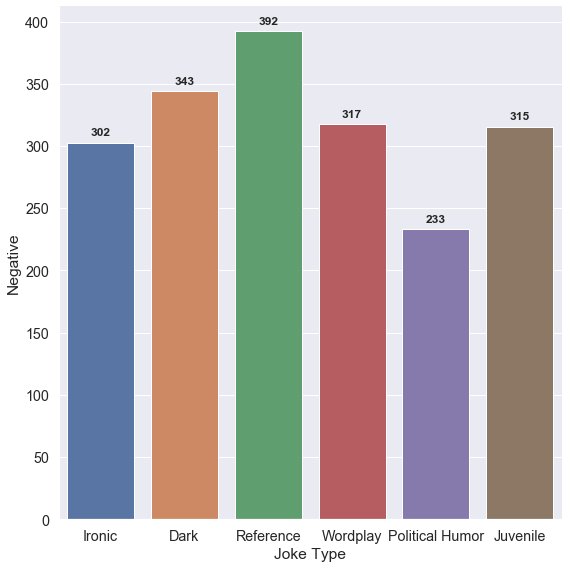

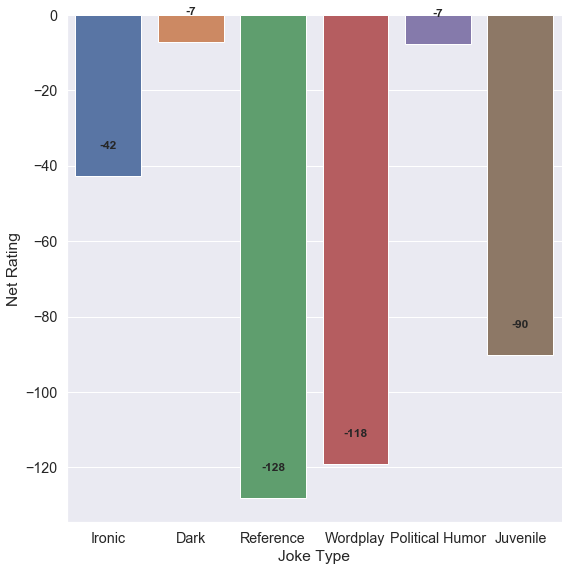

In [89]:
pos_plot = sb.catplot(y = "Positive",x="Joke Type", data = jokePos10_df, kind = "bar", height = 8, ci=None,)
for i, bar in enumerate(pos_plot.ax.patches):
    h = bar.get_height()
    pos_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)
    
neg_plot = sb.catplot(y = "Negative",x="Joke Type", data = jokeNeg10_df, kind = "bar", height = 8, ci=None)
for i, bar in enumerate(neg_plot.ax.patches):
    h = bar.get_height()
    neg_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)
    
net_plot = sb.catplot(y = "Net Rating",x="Joke Type", data = jokeNet10_df, kind = "bar", height = 8, ci=None)
for i, bar in enumerate(net_plot.ax.patches):
    h = bar.get_height()
    net_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+8, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12)

> Based on the catplot, the number of users in this cluster that rate positively and negatively dark and political humor category jokes are about 50/50

#### Legend for the Catplot: Ratings Range ( 10 to -10 )
Positive = No. of Users that gave that joke type positive ratings.  
Negative =  No. of Users that gave that joke type negative ratings.  
Net Ratings = Difference between No. of Users that rate positively and negatively.  
e.g. The lower the Net Ratings = The no. of Users that rate negatively is relatively more than the other type.  
e.g. Negative value of Net Ratings = The no. of Users that rate that type of joke negatively is more than what the Users that rated positively.  
(Net dislike of the joke)  


> From Catplot on difference between positive and negative value (Net Rating): Majority of Users generally give all categories of joke a negative ratings




From this, we can deduce that:
* 392/991 (~ 39%) Users in this cluster give Reference category jokes a negative rating
* 317/991 (~ 32%) Users in this cluster give Wordplay category jokes a negative rating
* 315/991 (~ 32%) Users in this cluster give Juvenile category jokes a negative rating
* Majority of the users dislike Dark and Reference joke
* Wordplay jokes are not as well like as compared todark and reference joke

## #6.2.3 Cluster 10: Dataframe & Table based on Type of Jokes

##### 'Most-Disliked and Least-Disliked'
- Mean Ratings of the most-disliked jokes (Reference and Wordplay)
- Mean Ratings of the least-disliked jokes (Dark)

In [90]:
#Cluster 10 Category:
cluster10_Ironic = cluster10_df.iloc[:,Ironic_list]
cluster10_Reference = cluster10_df.iloc[:,Reference_list]
cluster10_Wordplay = cluster10_df.iloc[:,Wordplay_list]
cluster10_Dark = cluster10_df.iloc[:,Dark_list]
cluster10_Juvenile = cluster10_df.iloc[:,Juvenile_list]
cluster10_Political = cluster10_df.iloc[:,Political_list]

In [91]:
#view dataframe
pd.set_option('display.max_rows',100)
#jokeList10_df

In [92]:
cluster1_Reference.describe()

Joke 3      Joke 4      Joke 7     Joke 11     Joke 12     Joke 15  \
count  952.000000  952.000000  952.000000  952.000000  952.000000  952.000000   
mean    -0.012857   -0.205347    2.416712    1.689937    2.011880    0.253582   
std      2.629013    2.333967    4.550138    3.795431    3.520696    4.776649   
min     -9.900000   -9.900000   -9.900000   -9.810000   -9.900000   -9.950000   
25%      0.000000    0.000000   -0.240000    0.000000    0.000000   -3.400000   
50%      0.000000    0.000000    3.180000    0.510000    1.460000    0.850000   
75%      0.000000    0.000000    5.870000    4.332500    4.760000    3.880000   
max      9.080000    8.880000    9.370000    9.320000    9.370000    9.320000   

          Joke 17     Joke 20     Joke 21     Joke 28  ...     Joke 54  \
count  952.000000  952.000000  952.000000  952.000000  ...  952.000000   
mean     0.318981    2.128876    4.185788    4.019800  ...    4.654475   
std      3.815397    4.330760    3.550598    3.485204  ...    3.605357   
min     -9.850000   -9.900000   -9.470000   -9.810000  ...   -9.810000   
25%     -1.952500   -0.490000    2.280000    1.877500  ...    2.480000   
50%      0.580000    2.645000    4.760000    4.510000  ...    5.390000   
75%      2.830000    5.390000    6.840000    6.712500  ...    7.430000   
max      9.370000    9.370000    9.370000    9.320000  ...    9.320000   

          Joke 55     Joke 57     Joke 58     Joke 68     Joke 82     Joke 83  \
count  952.000000  952.000000  952.000000  952.000000  952.000000  952.000000   
mean     0.685357   -0.152321   -0.520126    5.061113    0.194664    0.157679   
std      3.363304    2.700161    2.695700    3.386273    1.633183    1.835412   
min     -9.950000   -9.900000   -9.850000   -9.900000   -8.450000   -9.220000   
25%      0.000000    0.000000    0.000000    3.450000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    5.805000    0.000000    0.000000   
75%      2.330000    0.000000    0.000000    7.532500    0.000000    0.000000   
max      9.320000    9.170000    8.930000    9.370000    9.270000    9.030000   

          Joke 84     Joke 90     Joke 92  
count  952.000000  952.000000  952.000000  
mean     0.140725    0.172363    0.299065  
std      1.750319    1.756266    1.948952  
min     -9.900000   -9.510000   -9.320000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
max      9.030000    9.270000    9.320000  

[8 rows x 27 columns]

> Count : 991 Users in Cluster 10  
> Joke 3 , 4 ,7 , 11, 12 ... in Reference Category

### Making Dataframe and Boxplot for Reference,Wordplay,Dark and Political Humor Jokes

In [93]:
##Using each jokes in the category mean as one value
c10_Reference_mean = cluster10_Reference.mean().to_frame()
c10_Wordplay_mean = cluster10_Wordplay.mean().to_frame()
c10_Dark_mean = cluster10_Dark.mean().to_frame()

In [94]:
##Reference Joke: each Joke ID have mean value as 'final' ratings for that joke
c1_Reference_mean.head()

0
Joke 3  -0.012857
Joke 4  -0.205347
Joke 7   2.416712
Joke 11  1.689937
Joke 12  2.011880

In [95]:
c10_boxplot = pd.concat([c10_Reference_mean.rename(columns={ c10_Reference_mean.columns[0]: "Cluster10_Reference_Mean" })
,c10_Wordplay_mean.rename(columns={c10_Wordplay_mean.columns[0]: "Cluster10_Wordplay_Mean" }) ,c10_Dark_mean.rename(columns={ c10_Dark_mean.columns[0]: "Cluster10_Dark_Mean" }) ], axis=1, sort = True)

##### Statistical Description of Reference, Wordplay and Dark Jokes

In [96]:
c10_boxplot.describe().round(2)

Cluster10_Reference_Mean  Cluster10_Wordplay_Mean  Cluster10_Dark_Mean
count                     27.00                    27.00                13.00
mean                      -0.76                    -0.70                -0.15
std                        1.12                     1.08                 0.46
min                       -3.80                    -4.53                -0.86
25%                       -0.82                    -0.59                -0.44
50%                       -0.37                    -0.40                -0.06
75%                       -0.16                    -0.18                 0.17
max                        0.45                     0.77                 0.62

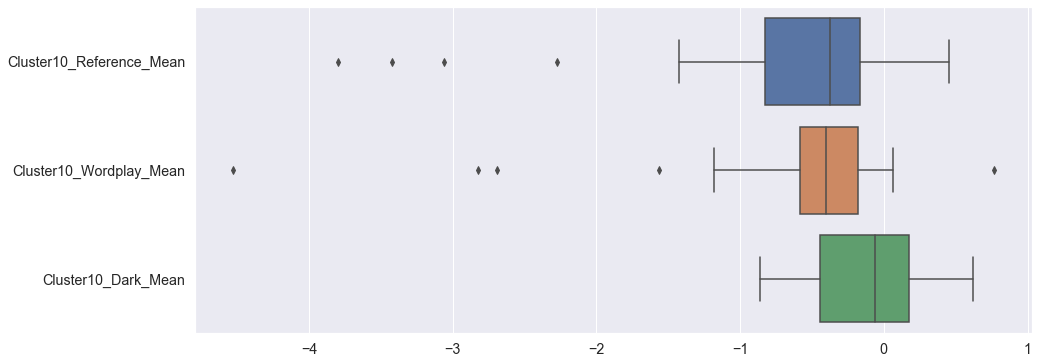

In [97]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))  ##height, width
sb.boxplot(data = c10_boxplot, orient = "h")

##### Short Description of the Boxplot:

In [98]:
print('Reference Category: Maximum Rating of %.2f is derived from %s and Minimum Rating of %.2f is derived from %s.'%(c10_boxplot["Cluster10_Reference_Mean"].max(),c10_boxplot["Cluster10_Reference_Mean"].idxmax(axis = 0),c10_boxplot["Cluster10_Reference_Mean"].min(),c10_boxplot["Cluster10_Reference_Mean"].idxmin(axis = 0)))
print('Wordplay Category Maximum rating of %.2f is derived from %s and Minimum Rating of %.2f is derived from %s.'%(c10_boxplot["Cluster10_Wordplay_Mean"].max(),c10_boxplot["Cluster10_Wordplay_Mean"].idxmax(axis = 0),c10_boxplot["Cluster10_Wordplay_Mean"].min(),c10_boxplot["Cluster10_Wordplay_Mean"].idxmin(axis = 0)))
print('Dark Category Maximum rating of %.2f is derived from %s and Minimum Rating of %.2f is derived from %s.'%(c10_boxplot["Cluster10_Dark_Mean"].max(),c10_boxplot["Cluster10_Dark_Mean"].idxmax(axis = 0),c10_boxplot["Cluster10_Dark_Mean"].min(),c10_boxplot["Cluster10_Dark_Mean"].idxmin(axis = 0)))

Reference Category: Maximum Rating of 0.45 is derived from Joke 21 and Minimum Rating of -3.80 is derived from Joke 20.
Wordplay Category Maximum rating of 0.77 is derived from Joke 65 and Minimum Rating of -4.53 is derived from Joke 16.
Dark Category Maximum rating of 0.62 is derived from Joke 53 and Minimum Rating of -0.86 is derived from Joke 38.


>  Inside Cluster 10: Reference and Wordplay are the most-disliked and Dark is the least-disliked.

## #6.2.4 Consolidated Analysis Based on Cluster 10:
From the heatmap:

we can see generally that Majority of the users in this cluster:

    *Neutral feeling towards jokes 70 - 99 (red in colour, 0)*
    *Jokes 15-19 (are not well-liked by the users)*
    *rated jokes negatively (generally all dark  pink and purple)* 

From Catplot on Positive and Negative Value:
The count of shows that users in this cluster that rate Dark category jokes are about 50/50 in terms of positive and negative ratings and they dislike jokes from Reference and Wordplay (Most No. of count of Negative Value)

From Catplot on difference between positive and negative value (Net Rating):
Majority of Users generally give all categories of joke negative ratings

From this, we can deduce that:
* 392/991 (~ 39%) users in this cluster give Reference category jokes a negative rating
* 317/991 (~ 32%) Users in this cluster give Wordplay category jokes a negative rating
* 315/991 (~ 32%) users in this cluster give Juvenile category jokes a negative rating
* Majority of the users dislike reference and wordplay joke
* Wordplay jokes are the least dislike among the users


From Boxplot of the Reference, Wordplay, Dark Category (derived from catplot previously):

Analysis into which specific type of jokes the users dislike: using c10_boxplot.describe()

Reference jokes :    c10_boxplot["Cluster10_Reference_Mean"].describe()
    
    Maximum Rating of 0.45 is derived from 21 Joke .
    Minimum Rating of -3.80 is derived from 20 Joke .
    Having a Mean of -0.76.

Wordplay:   c10_boxplot["Cluster10_Wordplay_Mean"].describe()

    Maximum rating of 0.77 is derived from 65 Joke .
    Minimum Rating of -4.53 is derived from 16 Joke .
    Having a Mean of -0.70.

Dark Jokes :   c10_boxplot["Cluster10_Dark_Mean"].describe()

    Maximum rating of 0.62 is derived from 53 Joke .
    Minimum Rating of -0.86 is derived from 38 Joke .
    Having a Mean of -0.15.


## #7: Conclusion
 
The Problem Statement : To identify whether there’s diverse group with contrasting likes and dislikes of various jokes.

#### The list below shows the contrast between the two clusters:

Cluster 1:
* generally give positive ratings to the jokes
* like 'Dark' and 'Reference' jokes
* particularly rate joke 32 and 35 the highest
* majority of the users in the cluster rate 'Reference' joke from 0 to +3

Cluster 10:
* generally give negative ratings to the jokes
* dislike 'Reference' and 'Wordplay' jokes
* particularly rate joke 20 and 26 the lowest
* majority of the users in the cluster rate 'Reference' joke from -1 to 0

#### There's contrasting likes and dislikes of 'reference' jokes between cluster 1 and 10.
#### Even within the group itself, there's diverse likes and dislikes of different type of joke. 
E.g. Cluster 1: Likes 'Dark' Jokes but Dislike 'Wordplay'.